In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1','fe':['b25'],'fi':['targets']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_coords_0_1_connectivity_data_norm_b25_targets_t1_normalized_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 2119)
(772408, 8)
validation
(101248, 2119)
(101248, 8)
test
(98888, 2119)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 2119)]            0         


 dense (Dense)               (None, 1024)              2170880   


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 2860936 (10.91 MB)


Trainable params: 2860936 (10.91 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/78 [..............................] - ETA: 1:44 - loss: 2.0746 - STD: 0.0849 - MAE: 0.2142

 3/78 [>.............................] - ETA: 2s - loss: 1.6730 - STD: 0.1280 - MAE: 0.1806  

 5/78 [>.............................] - ETA: 2s - loss: 1.5685 - STD: 0.1750 - MAE: 0.1585

 7/78 [=>............................] - ETA: 2s - loss: 1.5208 - STD: 0.1966 - MAE: 0.1485

 9/78 [==>...........................] - ETA: 2s - loss: 1.4830 - STD: 0.2020 - MAE: 0.1455

11/78 [===>..........................] - ETA: 2s - loss: 1.4592 - STD: 0.1983 - MAE: 0.1464

13/78 [====>.........................] - ETA: 2s - loss: 1.4445 - STD: 0.1928 - MAE: 0.1482

15/78 [====>.........................] - ETA: 2s - loss: 1.4314 - STD: 0.1892 - MAE: 0.1493

17/78 [=====>........................] - ETA: 2s - loss: 1.4185 - STD: 0.1886 - MAE: 0.1492

19/78 [======>.......................] - ETA: 2s - loss: 1.4096 - STD: 0.1900 - MAE: 0.1484

21/78 [=======>......................] - ETA: 2s - loss: 1.4016 - STD: 0.1920 - MAE: 0.1474

23/78 [=======>......................] - ETA: 2s - loss: 1.3958 - STD: 0.1938 - MAE: 0.1466

25/78 [========>.....................] - ETA: 2s - loss: 1.3906 - STD: 0.1946 - MAE: 0.1461

27/78 [=========>....................] - ETA: 2s - loss: 1.3860 - STD: 0.1945 - MAE: 0.1460

29/78 [==========>...................] - ETA: 2s - loss: 1.3819 - STD: 0.1938 - MAE: 0.1462

31/78 [==========>...................] - ETA: 2s - loss: 1.3781 - STD: 0.1928 - MAE: 0.1465

33/78 [===========>..................] - ETA: 2s - loss: 1.3746 - STD: 0.1920 - MAE: 0.1467

35/78 [============>.................] - ETA: 1s - loss: 1.3713 - STD: 0.1916 - MAE: 0.1468

37/78 [=============>................] - ETA: 1s - loss: 1.3681 - STD: 0.1916 - MAE: 0.1467

39/78 [==============>...............] - ETA: 1s - loss: 1.3647 - STD: 0.1920 - MAE: 0.1464

41/78 [==============>...............] - ETA: 1s - loss: 1.3628 - STD: 0.1924 - MAE: 0.1462

43/78 [===============>..............] - ETA: 1s - loss: 1.3603 - STD: 0.1927 - MAE: 0.1460

45/78 [================>.............] - ETA: 1s - loss: 1.3584 - STD: 0.1928 - MAE: 0.1459

46/78 [================>.............] - ETA: 1s - loss: 1.3582 - STD: 0.1928 - MAE: 0.1459

48/78 [=================>............] - ETA: 1s - loss: 1.3563 - STD: 0.1926 - MAE: 0.1460

50/78 [==================>...........] - ETA: 1s - loss: 1.3548 - STD: 0.1923 - MAE: 0.1460

52/78 [===================>..........] - ETA: 1s - loss: 1.3530 - STD: 0.1921 - MAE: 0.1461

54/78 [===================>..........] - ETA: 1s - loss: 1.3514 - STD: 0.1920 - MAE: 0.1460

56/78 [====================>.........] - ETA: 1s - loss: 1.3496 - STD: 0.1921 - MAE: 0.1459

58/78 [=====================>........] - ETA: 1s - loss: 1.3484 - STD: 0.1923 - MAE: 0.1458

60/78 [======================>.......] - ETA: 0s - loss: 1.3473 - STD: 0.1924 - MAE: 0.1458

62/78 [======================>.......] - ETA: 0s - loss: 1.3466 - STD: 0.1924 - MAE: 0.1458

64/78 [=======================>......] - ETA: 0s - loss: 1.3458 - STD: 0.1923 - MAE: 0.1458

66/78 [========================>.....] - ETA: 0s - loss: 1.3447 - STD: 0.1922 - MAE: 0.1458

68/78 [=========================>....] - ETA: 0s - loss: 1.3439 - STD: 0.1920 - MAE: 0.1458

70/78 [=========================>....] - ETA: 0s - loss: 1.3429 - STD: 0.1920 - MAE: 0.1458

72/78 [==========================>...] - ETA: 0s - loss: 1.3421 - STD: 0.1921 - MAE: 0.1458

74/78 [===========================>..] - ETA: 0s - loss: 1.3418 - STD: 0.1921 - MAE: 0.1458

76/78 [============================>.] - ETA: 0s - loss: 1.3414 - STD: 0.1922 - MAE: 0.1457

78/78 [==============================] - ETA: 0s - loss: 1.3407 - STD: 0.1921 - MAE: 0.1458

78/78 [==============================] - 6s 65ms/step - loss: 1.3407 - STD: 0.1921 - MAE: 0.1458 - val_loss: 1.2738 - val_STD: 0.1884 - val_MAE: 0.1462


Epoch 2/10000


 1/78 [..............................] - ETA: 6s - loss: 1.3007 - STD: 0.1883 - MAE: 0.1457

 3/78 [>.............................] - ETA: 3s - loss: 1.3151 - STD: 0.1886 - MAE: 0.1464

 5/78 [>.............................] - ETA: 3s - loss: 1.3158 - STD: 0.1891 - MAE: 0.1461

 7/78 [=>............................] - ETA: 3s - loss: 1.3146 - STD: 0.1900 - MAE: 0.1458

 9/78 [==>...........................] - ETA: 3s - loss: 1.3160 - STD: 0.1908 - MAE: 0.1456

11/78 [===>..........................] - ETA: 3s - loss: 1.3167 - STD: 0.1911 - MAE: 0.1456

13/78 [====>.........................] - ETA: 3s - loss: 1.3180 - STD: 0.1910 - MAE: 0.1457

15/78 [====>.........................] - ETA: 2s - loss: 1.3173 - STD: 0.1907 - MAE: 0.1457

17/78 [=====>........................] - ETA: 2s - loss: 1.3154 - STD: 0.1906 - MAE: 0.1456

19/78 [======>.......................] - ETA: 2s - loss: 1.3145 - STD: 0.1909 - MAE: 0.1455

21/78 [=======>......................] - ETA: 2s - loss: 1.3137 - STD: 0.1912 - MAE: 0.1453

23/78 [=======>......................] - ETA: 2s - loss: 1.3132 - STD: 0.1913 - MAE: 0.1452

25/78 [========>.....................] - ETA: 2s - loss: 1.3120 - STD: 0.1914 - MAE: 0.1451

26/78 [=========>....................] - ETA: 2s - loss: 1.3112 - STD: 0.1914 - MAE: 0.1451

28/78 [=========>....................] - ETA: 2s - loss: 1.3115 - STD: 0.1915 - MAE: 0.1451

30/78 [==========>...................] - ETA: 2s - loss: 1.3120 - STD: 0.1914 - MAE: 0.1451

32/78 [===========>..................] - ETA: 2s - loss: 1.3117 - STD: 0.1913 - MAE: 0.1452

34/78 [============>.................] - ETA: 2s - loss: 1.3112 - STD: 0.1912 - MAE: 0.1452

36/78 [============>.................] - ETA: 1s - loss: 1.3104 - STD: 0.1912 - MAE: 0.1451

38/78 [=============>................] - ETA: 1s - loss: 1.3105 - STD: 0.1913 - MAE: 0.1451

40/78 [==============>...............] - ETA: 1s - loss: 1.3095 - STD: 0.1912 - MAE: 0.1451

42/78 [===============>..............] - ETA: 1s - loss: 1.3090 - STD: 0.1912 - MAE: 0.1450

44/78 [===============>..............] - ETA: 1s - loss: 1.3077 - STD: 0.1913 - MAE: 0.1449

46/78 [================>.............] - ETA: 1s - loss: 1.3065 - STD: 0.1912 - MAE: 0.1449

48/78 [=================>............] - ETA: 1s - loss: 1.3053 - STD: 0.1913 - MAE: 0.1448

50/78 [==================>...........] - ETA: 1s - loss: 1.3039 - STD: 0.1913 - MAE: 0.1447

52/78 [===================>..........] - ETA: 1s - loss: 1.3023 - STD: 0.1914 - MAE: 0.1446

54/78 [===================>..........] - ETA: 1s - loss: 1.3008 - STD: 0.1916 - MAE: 0.1445

56/78 [====================>.........] - ETA: 1s - loss: 1.2995 - STD: 0.1917 - MAE: 0.1444

58/78 [=====================>........] - ETA: 0s - loss: 1.2984 - STD: 0.1919 - MAE: 0.1443

60/78 [======================>.......] - ETA: 0s - loss: 1.2969 - STD: 0.1920 - MAE: 0.1442

62/78 [======================>.......] - ETA: 0s - loss: 1.2952 - STD: 0.1922 - MAE: 0.1440

64/78 [=======================>......] - ETA: 0s - loss: 1.2938 - STD: 0.1923 - MAE: 0.1439

66/78 [========================>.....] - ETA: 0s - loss: 1.2921 - STD: 0.1926 - MAE: 0.1438

68/78 [=========================>....] - ETA: 0s - loss: 1.2906 - STD: 0.1926 - MAE: 0.1437

70/78 [=========================>....] - ETA: 0s - loss: 1.2892 - STD: 0.1929 - MAE: 0.1435

72/78 [==========================>...] - ETA: 0s - loss: 1.2873 - STD: 0.1930 - MAE: 0.1434

74/78 [===========================>..] - ETA: 0s - loss: 1.2861 - STD: 0.1931 - MAE: 0.1433

76/78 [============================>.] - ETA: 0s - loss: 1.2839 - STD: 0.1934 - MAE: 0.1431

78/78 [==============================] - ETA: 0s - loss: 1.2816 - STD: 0.1934 - MAE: 0.1430

78/78 [==============================] - 4s 54ms/step - loss: 1.2816 - STD: 0.1934 - MAE: 0.1430 - val_loss: 1.1640 - val_STD: 0.2004 - val_MAE: 0.1364


Epoch 3/10000


 1/78 [..............................] - ETA: 6s - loss: 1.2032 - STD: 0.2014 - MAE: 0.1372

 3/78 [>.............................] - ETA: 3s - loss: 1.2134 - STD: 0.2037 - MAE: 0.1371

 5/78 [>.............................] - ETA: 3s - loss: 1.2127 - STD: 0.2003 - MAE: 0.1383

 7/78 [=>............................] - ETA: 3s - loss: 1.2080 - STD: 0.2007 - MAE: 0.1379

 9/78 [==>...........................] - ETA: 3s - loss: 1.2058 - STD: 0.1998 - MAE: 0.1382

11/78 [===>..........................] - ETA: 3s - loss: 1.2011 - STD: 0.2003 - MAE: 0.1378

13/78 [====>.........................] - ETA: 3s - loss: 1.1985 - STD: 0.2006 - MAE: 0.1376

15/78 [====>.........................] - ETA: 3s - loss: 1.1946 - STD: 0.2006 - MAE: 0.1374

17/78 [=====>........................] - ETA: 2s - loss: 1.1913 - STD: 0.2010 - MAE: 0.1371

19/78 [======>.......................] - ETA: 2s - loss: 1.1882 - STD: 0.2007 - MAE: 0.1371

21/78 [=======>......................] - ETA: 2s - loss: 1.1845 - STD: 0.2012 - MAE: 0.1367

23/78 [=======>......................] - ETA: 2s - loss: 1.1822 - STD: 0.2014 - MAE: 0.1366

25/78 [========>.....................] - ETA: 2s - loss: 1.1798 - STD: 0.2016 - MAE: 0.1364

27/78 [=========>....................] - ETA: 2s - loss: 1.1776 - STD: 0.2017 - MAE: 0.1363

29/78 [==========>...................] - ETA: 2s - loss: 1.1756 - STD: 0.2019 - MAE: 0.1362

31/78 [==========>...................] - ETA: 2s - loss: 1.1729 - STD: 0.2019 - MAE: 0.1361

33/78 [===========>..................] - ETA: 2s - loss: 1.1705 - STD: 0.2018 - MAE: 0.1361

35/78 [============>.................] - ETA: 2s - loss: 1.1684 - STD: 0.2021 - MAE: 0.1358

37/78 [=============>................] - ETA: 1s - loss: 1.1673 - STD: 0.2020 - MAE: 0.1359

39/78 [==============>...............] - ETA: 1s - loss: 1.1655 - STD: 0.2022 - MAE: 0.1358

41/78 [==============>...............] - ETA: 1s - loss: 1.1640 - STD: 0.2024 - MAE: 0.1356

43/78 [===============>..............] - ETA: 1s - loss: 1.1622 - STD: 0.2022 - MAE: 0.1357

45/78 [================>.............] - ETA: 1s - loss: 1.1597 - STD: 0.2025 - MAE: 0.1355

47/78 [=================>............] - ETA: 1s - loss: 1.1580 - STD: 0.2025 - MAE: 0.1354

49/78 [=================>............] - ETA: 1s - loss: 1.1561 - STD: 0.2025 - MAE: 0.1354

51/78 [==================>...........] - ETA: 1s - loss: 1.1546 - STD: 0.2027 - MAE: 0.1353

53/78 [===================>..........] - ETA: 1s - loss: 1.1533 - STD: 0.2026 - MAE: 0.1353

55/78 [====================>.........] - ETA: 1s - loss: 1.1509 - STD: 0.2026 - MAE: 0.1352

57/78 [====================>.........] - ETA: 0s - loss: 1.1483 - STD: 0.2028 - MAE: 0.1350

59/78 [=====================>........] - ETA: 0s - loss: 1.1461 - STD: 0.2028 - MAE: 0.1350

61/78 [======================>.......] - ETA: 0s - loss: 1.1438 - STD: 0.2031 - MAE: 0.1348

63/78 [=======================>......] - ETA: 0s - loss: 1.1415 - STD: 0.2030 - MAE: 0.1347

65/78 [========================>.....] - ETA: 0s - loss: 1.1392 - STD: 0.2033 - MAE: 0.1345

67/78 [========================>.....] - ETA: 0s - loss: 1.1369 - STD: 0.2033 - MAE: 0.1344

69/78 [=========================>....] - ETA: 0s - loss: 1.1346 - STD: 0.2036 - MAE: 0.1343

71/78 [==========================>...] - ETA: 0s - loss: 1.1321 - STD: 0.2037 - MAE: 0.1341

73/78 [===========================>..] - ETA: 0s - loss: 1.1299 - STD: 0.2038 - MAE: 0.1340

75/78 [===========================>..] - ETA: 0s - loss: 1.1277 - STD: 0.2041 - MAE: 0.1338

77/78 [============================>.] - ETA: 0s - loss: 1.1253 - STD: 0.2041 - MAE: 0.1337

78/78 [==============================] - 4s 53ms/step - loss: 1.1241 - STD: 0.2043 - MAE: 0.1336 - val_loss: 1.0500 - val_STD: 0.2216 - val_MAE: 0.1231


Epoch 4/10000


 1/78 [..............................] - ETA: 6s - loss: 1.0505 - STD: 0.2198 - MAE: 0.1243

 3/78 [>.............................] - ETA: 3s - loss: 1.0306 - STD: 0.2098 - MAE: 0.1277

 5/78 [>.............................] - ETA: 3s - loss: 1.0318 - STD: 0.2108 - MAE: 0.1275

 7/78 [=>............................] - ETA: 3s - loss: 1.0315 - STD: 0.2118 - MAE: 0.1271

 9/78 [==>...........................] - ETA: 3s - loss: 1.0307 - STD: 0.2102 - MAE: 0.1277

11/78 [===>..........................] - ETA: 3s - loss: 1.0273 - STD: 0.2122 - MAE: 0.1267

13/78 [====>.........................] - ETA: 3s - loss: 1.0272 - STD: 0.2111 - MAE: 0.1271

15/78 [====>.........................] - ETA: 2s - loss: 1.0255 - STD: 0.2123 - MAE: 0.1265

17/78 [=====>........................] - ETA: 2s - loss: 1.0243 - STD: 0.2121 - MAE: 0.1266

19/78 [======>.......................] - ETA: 2s - loss: 1.0221 - STD: 0.2123 - MAE: 0.1264

21/78 [=======>......................] - ETA: 2s - loss: 1.0211 - STD: 0.2125 - MAE: 0.1262

23/78 [=======>......................] - ETA: 2s - loss: 1.0188 - STD: 0.2126 - MAE: 0.1261

25/78 [========>.....................] - ETA: 2s - loss: 1.0176 - STD: 0.2130 - MAE: 0.1258

27/78 [=========>....................] - ETA: 2s - loss: 1.0163 - STD: 0.2131 - MAE: 0.1257

29/78 [==========>...................] - ETA: 2s - loss: 1.0148 - STD: 0.2135 - MAE: 0.1254

31/78 [==========>...................] - ETA: 2s - loss: 1.0156 - STD: 0.2136 - MAE: 0.1254

33/78 [===========>..................] - ETA: 2s - loss: 1.0143 - STD: 0.2139 - MAE: 0.1252

35/78 [============>.................] - ETA: 2s - loss: 1.0135 - STD: 0.2142 - MAE: 0.1250

37/78 [=============>................] - ETA: 1s - loss: 1.0135 - STD: 0.2142 - MAE: 0.1251

39/78 [==============>...............] - ETA: 1s - loss: 1.0126 - STD: 0.2144 - MAE: 0.1249

41/78 [==============>...............] - ETA: 1s - loss: 1.0114 - STD: 0.2144 - MAE: 0.1248

43/78 [===============>..............] - ETA: 1s - loss: 1.0104 - STD: 0.2148 - MAE: 0.1246

45/78 [================>.............] - ETA: 1s - loss: 1.0098 - STD: 0.2148 - MAE: 0.1246

47/78 [=================>............] - ETA: 1s - loss: 1.0086 - STD: 0.2150 - MAE: 0.1244

49/78 [=================>............] - ETA: 1s - loss: 1.0076 - STD: 0.2152 - MAE: 0.1243

51/78 [==================>...........] - ETA: 1s - loss: 1.0065 - STD: 0.2153 - MAE: 0.1242

53/78 [===================>..........] - ETA: 1s - loss: 1.0059 - STD: 0.2154 - MAE: 0.1241

55/78 [====================>.........] - ETA: 1s - loss: 1.0045 - STD: 0.2155 - MAE: 0.1240

57/78 [====================>.........] - ETA: 1s - loss: 1.0035 - STD: 0.2157 - MAE: 0.1239

59/78 [=====================>........] - ETA: 0s - loss: 1.0024 - STD: 0.2159 - MAE: 0.1237

61/78 [======================>.......] - ETA: 0s - loss: 1.0015 - STD: 0.2161 - MAE: 0.1236

63/78 [=======================>......] - ETA: 0s - loss: 1.0008 - STD: 0.2160 - MAE: 0.1236

65/78 [========================>.....] - ETA: 0s - loss: 0.9997 - STD: 0.2161 - MAE: 0.1235

67/78 [========================>.....] - ETA: 0s - loss: 0.9990 - STD: 0.2164 - MAE: 0.1234

69/78 [=========================>....] - ETA: 0s - loss: 0.9981 - STD: 0.2164 - MAE: 0.1233

71/78 [==========================>...] - ETA: 0s - loss: 0.9974 - STD: 0.2164 - MAE: 0.1232

73/78 [===========================>..] - ETA: 0s - loss: 0.9965 - STD: 0.2166 - MAE: 0.1231

75/78 [===========================>..] - ETA: 0s - loss: 0.9954 - STD: 0.2168 - MAE: 0.1230

77/78 [============================>.] - ETA: 0s - loss: 0.9944 - STD: 0.2169 - MAE: 0.1229

78/78 [==============================] - 4s 54ms/step - loss: 0.9941 - STD: 0.2169 - MAE: 0.1229 - val_loss: 0.9775 - val_STD: 0.2172 - val_MAE: 0.1218


Epoch 5/10000


 1/78 [..............................] - ETA: 6s - loss: 0.9487 - STD: 0.2217 - MAE: 0.1184

 3/78 [>.............................] - ETA: 3s - loss: 0.9598 - STD: 0.2239 - MAE: 0.1180

 5/78 [>.............................] - ETA: 3s - loss: 0.9628 - STD: 0.2224 - MAE: 0.1187

 7/78 [=>............................] - ETA: 3s - loss: 0.9611 - STD: 0.2211 - MAE: 0.1193

 9/78 [==>...........................] - ETA: 3s - loss: 0.9609 - STD: 0.2227 - MAE: 0.1186

11/78 [===>..........................] - ETA: 3s - loss: 0.9622 - STD: 0.2220 - MAE: 0.1189

13/78 [====>.........................] - ETA: 3s - loss: 0.9620 - STD: 0.2213 - MAE: 0.1193

15/78 [====>.........................] - ETA: 3s - loss: 0.9611 - STD: 0.2223 - MAE: 0.1188

17/78 [=====>........................] - ETA: 2s - loss: 0.9613 - STD: 0.2216 - MAE: 0.1191

19/78 [======>.......................] - ETA: 2s - loss: 0.9593 - STD: 0.2217 - MAE: 0.1190

21/78 [=======>......................] - ETA: 2s - loss: 0.9586 - STD: 0.2226 - MAE: 0.1185

23/78 [=======>......................] - ETA: 2s - loss: 0.9572 - STD: 0.2220 - MAE: 0.1188

25/78 [========>.....................] - ETA: 2s - loss: 0.9561 - STD: 0.2223 - MAE: 0.1186

27/78 [=========>....................] - ETA: 2s - loss: 0.9552 - STD: 0.2227 - MAE: 0.1184

29/78 [==========>...................] - ETA: 2s - loss: 0.9547 - STD: 0.2222 - MAE: 0.1185

31/78 [==========>...................] - ETA: 2s - loss: 0.9543 - STD: 0.2227 - MAE: 0.1183

33/78 [===========>..................] - ETA: 2s - loss: 0.9529 - STD: 0.2225 - MAE: 0.1183

35/78 [============>.................] - ETA: 2s - loss: 0.9524 - STD: 0.2229 - MAE: 0.1181

37/78 [=============>................] - ETA: 1s - loss: 0.9516 - STD: 0.2228 - MAE: 0.1181

39/78 [==============>...............] - ETA: 1s - loss: 0.9518 - STD: 0.2227 - MAE: 0.1181

41/78 [==============>...............] - ETA: 1s - loss: 0.9511 - STD: 0.2231 - MAE: 0.1179

43/78 [===============>..............] - ETA: 1s - loss: 0.9509 - STD: 0.2227 - MAE: 0.1181

45/78 [================>.............] - ETA: 1s - loss: 0.9501 - STD: 0.2231 - MAE: 0.1179

47/78 [=================>............] - ETA: 1s - loss: 0.9494 - STD: 0.2230 - MAE: 0.1179

49/78 [=================>............] - ETA: 1s - loss: 0.9487 - STD: 0.2231 - MAE: 0.1179

51/78 [==================>...........] - ETA: 1s - loss: 0.9479 - STD: 0.2232 - MAE: 0.1178

53/78 [===================>..........] - ETA: 1s - loss: 0.9466 - STD: 0.2231 - MAE: 0.1177

55/78 [====================>.........] - ETA: 1s - loss: 0.9456 - STD: 0.2233 - MAE: 0.1176

57/78 [====================>.........] - ETA: 0s - loss: 0.9447 - STD: 0.2232 - MAE: 0.1176

59/78 [=====================>........] - ETA: 0s - loss: 0.9436 - STD: 0.2234 - MAE: 0.1175

61/78 [======================>.......] - ETA: 0s - loss: 0.9425 - STD: 0.2234 - MAE: 0.1174

63/78 [=======================>......] - ETA: 0s - loss: 0.9418 - STD: 0.2236 - MAE: 0.1173

65/78 [========================>.....] - ETA: 0s - loss: 0.9412 - STD: 0.2235 - MAE: 0.1173

67/78 [========================>.....] - ETA: 0s - loss: 0.9401 - STD: 0.2235 - MAE: 0.1173

69/78 [=========================>....] - ETA: 0s - loss: 0.9391 - STD: 0.2236 - MAE: 0.1172

71/78 [==========================>...] - ETA: 0s - loss: 0.9380 - STD: 0.2237 - MAE: 0.1171

73/78 [===========================>..] - ETA: 0s - loss: 0.9368 - STD: 0.2238 - MAE: 0.1170

75/78 [===========================>..] - ETA: 0s - loss: 0.9360 - STD: 0.2238 - MAE: 0.1169

77/78 [============================>.] - ETA: 0s - loss: 0.9351 - STD: 0.2239 - MAE: 0.1169

78/78 [==============================] - 4s 54ms/step - loss: 0.9347 - STD: 0.2241 - MAE: 0.1168 - val_loss: 0.9213 - val_STD: 0.2248 - val_MAE: 0.1163


Epoch 6/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8868 - STD: 0.2277 - MAE: 0.1129

 2/78 [..............................] - ETA: 3s - loss: 0.8894 - STD: 0.2207 - MAE: 0.1163

 4/78 [>.............................] - ETA: 3s - loss: 0.8947 - STD: 0.2285 - MAE: 0.1131

 6/78 [=>............................] - ETA: 2s - loss: 0.8981 - STD: 0.2274 - MAE: 0.1139

 8/78 [==>...........................] - ETA: 2s - loss: 0.8955 - STD: 0.2261 - MAE: 0.1143

10/78 [==>...........................] - ETA: 2s - loss: 0.8940 - STD: 0.2274 - MAE: 0.1137

12/78 [===>..........................] - ETA: 2s - loss: 0.8893 - STD: 0.2269 - MAE: 0.1136

14/78 [====>.........................] - ETA: 2s - loss: 0.8864 - STD: 0.2278 - MAE: 0.1131

16/78 [=====>........................] - ETA: 2s - loss: 0.8836 - STD: 0.2277 - MAE: 0.1130

18/78 [=====>........................] - ETA: 2s - loss: 0.8830 - STD: 0.2276 - MAE: 0.1131

20/78 [======>.......................] - ETA: 2s - loss: 0.8817 - STD: 0.2281 - MAE: 0.1128

22/78 [=======>......................] - ETA: 2s - loss: 0.8809 - STD: 0.2277 - MAE: 0.1130

24/78 [========>.....................] - ETA: 2s - loss: 0.8801 - STD: 0.2283 - MAE: 0.1127

26/78 [=========>....................] - ETA: 2s - loss: 0.8792 - STD: 0.2279 - MAE: 0.1129

27/78 [=========>....................] - ETA: 2s - loss: 0.8778 - STD: 0.2283 - MAE: 0.1127

29/78 [==========>...................] - ETA: 2s - loss: 0.8779 - STD: 0.2282 - MAE: 0.1127

31/78 [==========>...................] - ETA: 2s - loss: 0.8777 - STD: 0.2288 - MAE: 0.1125

33/78 [===========>..................] - ETA: 2s - loss: 0.8778 - STD: 0.2284 - MAE: 0.1127

35/78 [============>.................] - ETA: 1s - loss: 0.8775 - STD: 0.2286 - MAE: 0.1125

37/78 [=============>................] - ETA: 1s - loss: 0.8768 - STD: 0.2285 - MAE: 0.1126

39/78 [==============>...............] - ETA: 1s - loss: 0.8761 - STD: 0.2287 - MAE: 0.1124

41/78 [==============>...............] - ETA: 1s - loss: 0.8750 - STD: 0.2287 - MAE: 0.1124

43/78 [===============>..............] - ETA: 1s - loss: 0.8743 - STD: 0.2286 - MAE: 0.1124

45/78 [================>.............] - ETA: 1s - loss: 0.8730 - STD: 0.2288 - MAE: 0.1123

47/78 [=================>............] - ETA: 1s - loss: 0.8719 - STD: 0.2288 - MAE: 0.1122

49/78 [=================>............] - ETA: 1s - loss: 0.8711 - STD: 0.2290 - MAE: 0.1121

51/78 [==================>...........] - ETA: 1s - loss: 0.8701 - STD: 0.2291 - MAE: 0.1120

53/78 [===================>..........] - ETA: 1s - loss: 0.8689 - STD: 0.2292 - MAE: 0.1119

55/78 [====================>.........] - ETA: 1s - loss: 0.8682 - STD: 0.2292 - MAE: 0.1118

57/78 [====================>.........] - ETA: 0s - loss: 0.8669 - STD: 0.2294 - MAE: 0.1117

59/78 [=====================>........] - ETA: 0s - loss: 0.8662 - STD: 0.2295 - MAE: 0.1116

61/78 [======================>.......] - ETA: 0s - loss: 0.8655 - STD: 0.2295 - MAE: 0.1116

63/78 [=======================>......] - ETA: 0s - loss: 0.8643 - STD: 0.2297 - MAE: 0.1114

65/78 [========================>.....] - ETA: 0s - loss: 0.8637 - STD: 0.2298 - MAE: 0.1114

67/78 [========================>.....] - ETA: 0s - loss: 0.8627 - STD: 0.2299 - MAE: 0.1113

69/78 [=========================>....] - ETA: 0s - loss: 0.8619 - STD: 0.2300 - MAE: 0.1112

71/78 [==========================>...] - ETA: 0s - loss: 0.8614 - STD: 0.2300 - MAE: 0.1112

73/78 [===========================>..] - ETA: 0s - loss: 0.8606 - STD: 0.2301 - MAE: 0.1111

75/78 [===========================>..] - ETA: 0s - loss: 0.8602 - STD: 0.2301 - MAE: 0.1111

77/78 [============================>.] - ETA: 0s - loss: 0.8596 - STD: 0.2303 - MAE: 0.1110

78/78 [==============================] - 4s 54ms/step - loss: 0.8591 - STD: 0.2302 - MAE: 0.1110 - val_loss: 0.9067 - val_STD: 0.2361 - val_MAE: 0.1100


Epoch 7/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8415 - STD: 0.2383 - MAE: 0.1066

 3/78 [>.............................] - ETA: 3s - loss: 0.8414 - STD: 0.2311 - MAE: 0.1098

 5/78 [>.............................] - ETA: 3s - loss: 0.8341 - STD: 0.2354 - MAE: 0.1074

 7/78 [=>............................] - ETA: 3s - loss: 0.8348 - STD: 0.2331 - MAE: 0.1086

 9/78 [==>...........................] - ETA: 3s - loss: 0.8327 - STD: 0.2334 - MAE: 0.1084

10/78 [==>...........................] - ETA: 3s - loss: 0.8310 - STD: 0.2334 - MAE: 0.1083

12/78 [===>..........................] - ETA: 3s - loss: 0.8290 - STD: 0.2340 - MAE: 0.1080

14/78 [====>.........................] - ETA: 3s - loss: 0.8269 - STD: 0.2344 - MAE: 0.1076

16/78 [=====>........................] - ETA: 2s - loss: 0.8280 - STD: 0.2337 - MAE: 0.1081

18/78 [=====>........................] - ETA: 2s - loss: 0.8271 - STD: 0.2348 - MAE: 0.1075

20/78 [======>.......................] - ETA: 2s - loss: 0.8267 - STD: 0.2343 - MAE: 0.1078

22/78 [=======>......................] - ETA: 2s - loss: 0.8274 - STD: 0.2344 - MAE: 0.1078

24/78 [========>.....................] - ETA: 2s - loss: 0.8271 - STD: 0.2343 - MAE: 0.1077

26/78 [=========>....................] - ETA: 2s - loss: 0.8267 - STD: 0.2342 - MAE: 0.1078

28/78 [=========>....................] - ETA: 2s - loss: 0.8260 - STD: 0.2343 - MAE: 0.1077

30/78 [==========>...................] - ETA: 2s - loss: 0.8256 - STD: 0.2341 - MAE: 0.1078

32/78 [===========>..................] - ETA: 2s - loss: 0.8248 - STD: 0.2344 - MAE: 0.1076

34/78 [============>.................] - ETA: 2s - loss: 0.8250 - STD: 0.2342 - MAE: 0.1077

36/78 [============>.................] - ETA: 1s - loss: 0.8234 - STD: 0.2344 - MAE: 0.1075

38/78 [=============>................] - ETA: 1s - loss: 0.8226 - STD: 0.2345 - MAE: 0.1074

40/78 [==============>...............] - ETA: 1s - loss: 0.8220 - STD: 0.2346 - MAE: 0.1073

42/78 [===============>..............] - ETA: 1s - loss: 0.8217 - STD: 0.2346 - MAE: 0.1073

44/78 [===============>..............] - ETA: 1s - loss: 0.8219 - STD: 0.2347 - MAE: 0.1073

46/78 [================>.............] - ETA: 1s - loss: 0.8211 - STD: 0.2347 - MAE: 0.1072

48/78 [=================>............] - ETA: 1s - loss: 0.8204 - STD: 0.2347 - MAE: 0.1072

50/78 [==================>...........] - ETA: 1s - loss: 0.8207 - STD: 0.2348 - MAE: 0.1072

52/78 [===================>..........] - ETA: 1s - loss: 0.8207 - STD: 0.2349 - MAE: 0.1071

54/78 [===================>..........] - ETA: 1s - loss: 0.8205 - STD: 0.2348 - MAE: 0.1071

56/78 [====================>.........] - ETA: 1s - loss: 0.8202 - STD: 0.2350 - MAE: 0.1071

58/78 [=====================>........] - ETA: 0s - loss: 0.8195 - STD: 0.2350 - MAE: 0.1070

60/78 [======================>.......] - ETA: 0s - loss: 0.8186 - STD: 0.2350 - MAE: 0.1070

62/78 [======================>.......] - ETA: 0s - loss: 0.8180 - STD: 0.2351 - MAE: 0.1069

64/78 [=======================>......] - ETA: 0s - loss: 0.8176 - STD: 0.2352 - MAE: 0.1069

66/78 [========================>.....] - ETA: 0s - loss: 0.8172 - STD: 0.2351 - MAE: 0.1068

68/78 [=========================>....] - ETA: 0s - loss: 0.8171 - STD: 0.2351 - MAE: 0.1069

70/78 [=========================>....] - ETA: 0s - loss: 0.8170 - STD: 0.2352 - MAE: 0.1068

72/78 [==========================>...] - ETA: 0s - loss: 0.8168 - STD: 0.2353 - MAE: 0.1068

74/78 [===========================>..] - ETA: 0s - loss: 0.8169 - STD: 0.2355 - MAE: 0.1067

76/78 [============================>.] - ETA: 0s - loss: 0.8169 - STD: 0.2352 - MAE: 0.1068

78/78 [==============================] - ETA: 0s - loss: 0.8175 - STD: 0.2354 - MAE: 0.1068

78/78 [==============================] - 4s 53ms/step - loss: 0.8175 - STD: 0.2354 - MAE: 0.1068 - val_loss: 0.8931 - val_STD: 0.2204 - val_MAE: 0.1186


Epoch 8/10000


 1/78 [..............................] - ETA: 6s - loss: 0.8392 - STD: 0.2208 - MAE: 0.1152

 3/78 [>.............................] - ETA: 3s - loss: 0.8189 - STD: 0.2368 - MAE: 0.1064

 5/78 [>.............................] - ETA: 3s - loss: 0.8114 - STD: 0.2347 - MAE: 0.1069

 7/78 [=>............................] - ETA: 2s - loss: 0.8058 - STD: 0.2363 - MAE: 0.1059

 9/78 [==>...........................] - ETA: 2s - loss: 0.8041 - STD: 0.2359 - MAE: 0.1059

11/78 [===>..........................] - ETA: 2s - loss: 0.8015 - STD: 0.2366 - MAE: 0.1055

13/78 [====>.........................] - ETA: 2s - loss: 0.8013 - STD: 0.2358 - MAE: 0.1058

15/78 [====>.........................] - ETA: 2s - loss: 0.8005 - STD: 0.2367 - MAE: 0.1053

17/78 [=====>........................] - ETA: 2s - loss: 0.8009 - STD: 0.2364 - MAE: 0.1055

19/78 [======>.......................] - ETA: 2s - loss: 0.8010 - STD: 0.2369 - MAE: 0.1053

21/78 [=======>......................] - ETA: 2s - loss: 0.8006 - STD: 0.2368 - MAE: 0.1053

23/78 [=======>......................] - ETA: 2s - loss: 0.8003 - STD: 0.2368 - MAE: 0.1053

25/78 [========>.....................] - ETA: 2s - loss: 0.7997 - STD: 0.2368 - MAE: 0.1053

27/78 [=========>....................] - ETA: 2s - loss: 0.7987 - STD: 0.2370 - MAE: 0.1051

29/78 [==========>...................] - ETA: 2s - loss: 0.7980 - STD: 0.2369 - MAE: 0.1051

31/78 [==========>...................] - ETA: 2s - loss: 0.7971 - STD: 0.2372 - MAE: 0.1050

33/78 [===========>..................] - ETA: 2s - loss: 0.7970 - STD: 0.2370 - MAE: 0.1051

35/78 [============>.................] - ETA: 1s - loss: 0.7965 - STD: 0.2373 - MAE: 0.1049

37/78 [=============>................] - ETA: 1s - loss: 0.7963 - STD: 0.2373 - MAE: 0.1049

39/78 [==============>...............] - ETA: 1s - loss: 0.7965 - STD: 0.2374 - MAE: 0.1048

41/78 [==============>...............] - ETA: 1s - loss: 0.7967 - STD: 0.2373 - MAE: 0.1049

43/78 [===============>..............] - ETA: 1s - loss: 0.7959 - STD: 0.2375 - MAE: 0.1048

45/78 [================>.............] - ETA: 1s - loss: 0.7961 - STD: 0.2374 - MAE: 0.1048

47/78 [=================>............] - ETA: 1s - loss: 0.7960 - STD: 0.2374 - MAE: 0.1049

49/78 [=================>............] - ETA: 1s - loss: 0.7964 - STD: 0.2374 - MAE: 0.1049

51/78 [==================>...........] - ETA: 1s - loss: 0.7958 - STD: 0.2374 - MAE: 0.1048

53/78 [===================>..........] - ETA: 1s - loss: 0.7953 - STD: 0.2374 - MAE: 0.1048

55/78 [====================>.........] - ETA: 1s - loss: 0.7953 - STD: 0.2374 - MAE: 0.1048

57/78 [====================>.........] - ETA: 0s - loss: 0.7949 - STD: 0.2375 - MAE: 0.1047

59/78 [=====================>........] - ETA: 0s - loss: 0.7945 - STD: 0.2374 - MAE: 0.1047

61/78 [======================>.......] - ETA: 0s - loss: 0.7946 - STD: 0.2374 - MAE: 0.1048

63/78 [=======================>......] - ETA: 0s - loss: 0.7945 - STD: 0.2376 - MAE: 0.1047

65/78 [========================>.....] - ETA: 0s - loss: 0.7945 - STD: 0.2375 - MAE: 0.1047

67/78 [========================>.....] - ETA: 0s - loss: 0.7942 - STD: 0.2375 - MAE: 0.1047

69/78 [=========================>....] - ETA: 0s - loss: 0.7945 - STD: 0.2375 - MAE: 0.1047

71/78 [==========================>...] - ETA: 0s - loss: 0.7947 - STD: 0.2377 - MAE: 0.1046

73/78 [===========================>..] - ETA: 0s - loss: 0.7944 - STD: 0.2375 - MAE: 0.1047

75/78 [===========================>..] - ETA: 0s - loss: 0.7945 - STD: 0.2376 - MAE: 0.1046

77/78 [============================>.] - ETA: 0s - loss: 0.7946 - STD: 0.2377 - MAE: 0.1047

78/78 [==============================] - 4s 53ms/step - loss: 0.7945 - STD: 0.2377 - MAE: 0.1046 - val_loss: 0.8592 - val_STD: 0.2310 - val_MAE: 0.1120


Epoch 9/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7803 - STD: 0.2333 - MAE: 0.1059

 3/78 [>.............................] - ETA: 3s - loss: 0.7899 - STD: 0.2360 - MAE: 0.1052

 5/78 [>.............................] - ETA: 3s - loss: 0.7829 - STD: 0.2372 - MAE: 0.1042

 7/78 [=>............................] - ETA: 3s - loss: 0.7817 - STD: 0.2382 - MAE: 0.1037

 9/78 [==>...........................] - ETA: 3s - loss: 0.7800 - STD: 0.2378 - MAE: 0.1037

11/78 [===>..........................] - ETA: 3s - loss: 0.7805 - STD: 0.2385 - MAE: 0.1035

13/78 [====>.........................] - ETA: 3s - loss: 0.7820 - STD: 0.2386 - MAE: 0.1036

15/78 [====>.........................] - ETA: 2s - loss: 0.7818 - STD: 0.2383 - MAE: 0.1037

17/78 [=====>........................] - ETA: 2s - loss: 0.7820 - STD: 0.2386 - MAE: 0.1036

19/78 [======>.......................] - ETA: 2s - loss: 0.7818 - STD: 0.2392 - MAE: 0.1033

21/78 [=======>......................] - ETA: 2s - loss: 0.7827 - STD: 0.2388 - MAE: 0.1035

23/78 [=======>......................] - ETA: 2s - loss: 0.7846 - STD: 0.2390 - MAE: 0.1036

25/78 [========>.....................] - ETA: 2s - loss: 0.7848 - STD: 0.2393 - MAE: 0.1035

27/78 [=========>....................] - ETA: 2s - loss: 0.7859 - STD: 0.2389 - MAE: 0.1037

29/78 [==========>...................] - ETA: 2s - loss: 0.7865 - STD: 0.2393 - MAE: 0.1036

31/78 [==========>...................] - ETA: 2s - loss: 0.7863 - STD: 0.2391 - MAE: 0.1036

33/78 [===========>..................] - ETA: 2s - loss: 0.7861 - STD: 0.2392 - MAE: 0.1036

35/78 [============>.................] - ETA: 1s - loss: 0.7854 - STD: 0.2392 - MAE: 0.1036

37/78 [=============>................] - ETA: 1s - loss: 0.7852 - STD: 0.2390 - MAE: 0.1036

39/78 [==============>...............] - ETA: 1s - loss: 0.7850 - STD: 0.2391 - MAE: 0.1036

41/78 [==============>...............] - ETA: 1s - loss: 0.7851 - STD: 0.2391 - MAE: 0.1036

43/78 [===============>..............] - ETA: 1s - loss: 0.7846 - STD: 0.2389 - MAE: 0.1036

45/78 [================>.............] - ETA: 1s - loss: 0.7832 - STD: 0.2392 - MAE: 0.1034

47/78 [=================>............] - ETA: 1s - loss: 0.7829 - STD: 0.2391 - MAE: 0.1035

49/78 [=================>............] - ETA: 1s - loss: 0.7820 - STD: 0.2391 - MAE: 0.1034

51/78 [==================>...........] - ETA: 1s - loss: 0.7815 - STD: 0.2391 - MAE: 0.1034

53/78 [===================>..........] - ETA: 1s - loss: 0.7810 - STD: 0.2391 - MAE: 0.1033

55/78 [====================>.........] - ETA: 1s - loss: 0.7807 - STD: 0.2391 - MAE: 0.1033

57/78 [====================>.........] - ETA: 0s - loss: 0.7802 - STD: 0.2393 - MAE: 0.1032

59/78 [=====================>........] - ETA: 0s - loss: 0.7798 - STD: 0.2394 - MAE: 0.1032

61/78 [======================>.......] - ETA: 0s - loss: 0.7794 - STD: 0.2392 - MAE: 0.1032

63/78 [=======================>......] - ETA: 0s - loss: 0.7791 - STD: 0.2394 - MAE: 0.1031

65/78 [========================>.....] - ETA: 0s - loss: 0.7792 - STD: 0.2394 - MAE: 0.1032

67/78 [========================>.....] - ETA: 0s - loss: 0.7787 - STD: 0.2394 - MAE: 0.1031

69/78 [=========================>....] - ETA: 0s - loss: 0.7784 - STD: 0.2394 - MAE: 0.1031

71/78 [==========================>...] - ETA: 0s - loss: 0.7788 - STD: 0.2395 - MAE: 0.1031

73/78 [===========================>..] - ETA: 0s - loss: 0.7786 - STD: 0.2394 - MAE: 0.1031

75/78 [===========================>..] - ETA: 0s - loss: 0.7784 - STD: 0.2395 - MAE: 0.1030

77/78 [============================>.] - ETA: 0s - loss: 0.7785 - STD: 0.2394 - MAE: 0.1031

78/78 [==============================] - 4s 53ms/step - loss: 0.7783 - STD: 0.2395 - MAE: 0.1030 - val_loss: 0.8448 - val_STD: 0.2369 - val_MAE: 0.1088


Epoch 10/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7757 - STD: 0.2383 - MAE: 0.1034

 3/78 [>.............................] - ETA: 3s - loss: 0.7675 - STD: 0.2397 - MAE: 0.1023

 5/78 [>.............................] - ETA: 3s - loss: 0.7667 - STD: 0.2385 - MAE: 0.1028

 7/78 [=>............................] - ETA: 3s - loss: 0.7697 - STD: 0.2409 - MAE: 0.1018

 9/78 [==>...........................] - ETA: 3s - loss: 0.7693 - STD: 0.2391 - MAE: 0.1028

11/78 [===>..........................] - ETA: 3s - loss: 0.7709 - STD: 0.2400 - MAE: 0.1025

13/78 [====>.........................] - ETA: 3s - loss: 0.7719 - STD: 0.2405 - MAE: 0.1023

15/78 [====>.........................] - ETA: 2s - loss: 0.7722 - STD: 0.2400 - MAE: 0.1025

17/78 [=====>........................] - ETA: 2s - loss: 0.7736 - STD: 0.2404 - MAE: 0.1024

19/78 [======>.......................] - ETA: 2s - loss: 0.7732 - STD: 0.2402 - MAE: 0.1025

21/78 [=======>......................] - ETA: 2s - loss: 0.7726 - STD: 0.2403 - MAE: 0.1024

23/78 [=======>......................] - ETA: 2s - loss: 0.7723 - STD: 0.2402 - MAE: 0.1024

25/78 [========>.....................] - ETA: 2s - loss: 0.7711 - STD: 0.2401 - MAE: 0.1023

27/78 [=========>....................] - ETA: 2s - loss: 0.7706 - STD: 0.2402 - MAE: 0.1023

29/78 [==========>...................] - ETA: 2s - loss: 0.7701 - STD: 0.2402 - MAE: 0.1023

31/78 [==========>...................] - ETA: 2s - loss: 0.7688 - STD: 0.2401 - MAE: 0.1022

33/78 [===========>..................] - ETA: 2s - loss: 0.7678 - STD: 0.2403 - MAE: 0.1021

35/78 [============>.................] - ETA: 2s - loss: 0.7675 - STD: 0.2402 - MAE: 0.1021

37/78 [=============>................] - ETA: 1s - loss: 0.7667 - STD: 0.2404 - MAE: 0.1020

39/78 [==============>...............] - ETA: 1s - loss: 0.7662 - STD: 0.2403 - MAE: 0.1020

41/78 [==============>...............] - ETA: 1s - loss: 0.7653 - STD: 0.2405 - MAE: 0.1019

43/78 [===============>..............] - ETA: 1s - loss: 0.7651 - STD: 0.2404 - MAE: 0.1019

45/78 [================>.............] - ETA: 1s - loss: 0.7647 - STD: 0.2407 - MAE: 0.1017

47/78 [=================>............] - ETA: 1s - loss: 0.7639 - STD: 0.2406 - MAE: 0.1017

49/78 [=================>............] - ETA: 1s - loss: 0.7634 - STD: 0.2407 - MAE: 0.1016

51/78 [==================>...........] - ETA: 1s - loss: 0.7634 - STD: 0.2408 - MAE: 0.1016

53/78 [===================>..........] - ETA: 1s - loss: 0.7629 - STD: 0.2407 - MAE: 0.1016

55/78 [====================>.........] - ETA: 1s - loss: 0.7622 - STD: 0.2410 - MAE: 0.1015

57/78 [====================>.........] - ETA: 0s - loss: 0.7620 - STD: 0.2409 - MAE: 0.1015

59/78 [=====================>........] - ETA: 0s - loss: 0.7621 - STD: 0.2409 - MAE: 0.1015

61/78 [======================>.......] - ETA: 0s - loss: 0.7621 - STD: 0.2411 - MAE: 0.1014

63/78 [=======================>......] - ETA: 0s - loss: 0.7623 - STD: 0.2411 - MAE: 0.1014

65/78 [========================>.....] - ETA: 0s - loss: 0.7622 - STD: 0.2411 - MAE: 0.1014

67/78 [========================>.....] - ETA: 0s - loss: 0.7621 - STD: 0.2412 - MAE: 0.1014

69/78 [=========================>....] - ETA: 0s - loss: 0.7620 - STD: 0.2412 - MAE: 0.1014

71/78 [==========================>...] - ETA: 0s - loss: 0.7621 - STD: 0.2411 - MAE: 0.1014

72/78 [==========================>...] - ETA: 0s - loss: 0.7624 - STD: 0.2411 - MAE: 0.1015

74/78 [===========================>..] - ETA: 0s - loss: 0.7622 - STD: 0.2412 - MAE: 0.1014

76/78 [============================>.] - ETA: 0s - loss: 0.7630 - STD: 0.2412 - MAE: 0.1014

78/78 [==============================] - ETA: 0s - loss: 0.7629 - STD: 0.2411 - MAE: 0.1015

78/78 [==============================] - 4s 53ms/step - loss: 0.7629 - STD: 0.2411 - MAE: 0.1015 - val_loss: 0.8497 - val_STD: 0.2387 - val_MAE: 0.1074


Epoch 11/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7661 - STD: 0.2421 - MAE: 0.1010

 3/78 [>.............................] - ETA: 3s - loss: 0.7702 - STD: 0.2414 - MAE: 0.1018

 5/78 [>.............................] - ETA: 3s - loss: 0.7642 - STD: 0.2421 - MAE: 0.1012

 7/78 [=>............................] - ETA: 3s - loss: 0.7609 - STD: 0.2416 - MAE: 0.1012

 9/78 [==>...........................] - ETA: 3s - loss: 0.7613 - STD: 0.2416 - MAE: 0.1012

11/78 [===>..........................] - ETA: 3s - loss: 0.7604 - STD: 0.2419 - MAE: 0.1010

13/78 [====>.........................] - ETA: 3s - loss: 0.7586 - STD: 0.2417 - MAE: 0.1010

15/78 [====>.........................] - ETA: 2s - loss: 0.7574 - STD: 0.2417 - MAE: 0.1010

17/78 [=====>........................] - ETA: 2s - loss: 0.7559 - STD: 0.2417 - MAE: 0.1008

19/78 [======>.......................] - ETA: 2s - loss: 0.7541 - STD: 0.2418 - MAE: 0.1007

21/78 [=======>......................] - ETA: 2s - loss: 0.7527 - STD: 0.2420 - MAE: 0.1005

23/78 [=======>......................] - ETA: 2s - loss: 0.7515 - STD: 0.2420 - MAE: 0.1004

25/78 [========>.....................] - ETA: 2s - loss: 0.7504 - STD: 0.2419 - MAE: 0.1004

27/78 [=========>....................] - ETA: 2s - loss: 0.7501 - STD: 0.2422 - MAE: 0.1003

29/78 [==========>...................] - ETA: 2s - loss: 0.7498 - STD: 0.2422 - MAE: 0.1003

31/78 [==========>...................] - ETA: 2s - loss: 0.7493 - STD: 0.2422 - MAE: 0.1002

33/78 [===========>..................] - ETA: 2s - loss: 0.7494 - STD: 0.2424 - MAE: 0.1001

35/78 [============>.................] - ETA: 1s - loss: 0.7495 - STD: 0.2425 - MAE: 0.1001

37/78 [=============>................] - ETA: 1s - loss: 0.7488 - STD: 0.2423 - MAE: 0.1001

39/78 [==============>...............] - ETA: 1s - loss: 0.7488 - STD: 0.2426 - MAE: 0.1000

41/78 [==============>...............] - ETA: 1s - loss: 0.7485 - STD: 0.2426 - MAE: 0.1000

43/78 [===============>..............] - ETA: 1s - loss: 0.7485 - STD: 0.2425 - MAE: 0.1000

45/78 [================>.............] - ETA: 1s - loss: 0.7488 - STD: 0.2425 - MAE: 0.1000

47/78 [=================>............] - ETA: 1s - loss: 0.7485 - STD: 0.2425 - MAE: 0.1000

49/78 [=================>............] - ETA: 1s - loss: 0.7486 - STD: 0.2425 - MAE: 0.1000

51/78 [==================>...........] - ETA: 1s - loss: 0.7481 - STD: 0.2426 - MAE: 0.1000

53/78 [===================>..........] - ETA: 1s - loss: 0.7489 - STD: 0.2427 - MAE: 0.1000

55/78 [====================>.........] - ETA: 1s - loss: 0.7487 - STD: 0.2426 - MAE: 0.1000

57/78 [====================>.........] - ETA: 0s - loss: 0.7490 - STD: 0.2426 - MAE: 0.1000

59/78 [=====================>........] - ETA: 0s - loss: 0.7490 - STD: 0.2427 - MAE: 0.1000

61/78 [======================>.......] - ETA: 0s - loss: 0.7491 - STD: 0.2426 - MAE: 0.1000

63/78 [=======================>......] - ETA: 0s - loss: 0.7490 - STD: 0.2427 - MAE: 0.1000

65/78 [========================>.....] - ETA: 0s - loss: 0.7488 - STD: 0.2427 - MAE: 0.1000

67/78 [========================>.....] - ETA: 0s - loss: 0.7489 - STD: 0.2426 - MAE: 0.1000

69/78 [=========================>....] - ETA: 0s - loss: 0.7488 - STD: 0.2428 - MAE: 0.1000

71/78 [==========================>...] - ETA: 0s - loss: 0.7485 - STD: 0.2427 - MAE: 0.1000

73/78 [===========================>..] - ETA: 0s - loss: 0.7483 - STD: 0.2427 - MAE: 0.1000

75/78 [===========================>..] - ETA: 0s - loss: 0.7481 - STD: 0.2428 - MAE: 0.0999

77/78 [============================>.] - ETA: 0s - loss: 0.7480 - STD: 0.2427 - MAE: 0.1000

78/78 [==============================] - 4s 54ms/step - loss: 0.7483 - STD: 0.2428 - MAE: 0.0999 - val_loss: 0.8198 - val_STD: 0.2430 - val_MAE: 0.1046


Epoch 12/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7437 - STD: 0.2448 - MAE: 0.0989

 3/78 [>.............................] - ETA: 3s - loss: 0.7542 - STD: 0.2418 - MAE: 0.1010

 5/78 [>.............................] - ETA: 3s - loss: 0.7481 - STD: 0.2426 - MAE: 0.1003

 7/78 [=>............................] - ETA: 3s - loss: 0.7462 - STD: 0.2441 - MAE: 0.0993

 9/78 [==>...........................] - ETA: 3s - loss: 0.7474 - STD: 0.2425 - MAE: 0.1002

11/78 [===>..........................] - ETA: 3s - loss: 0.7483 - STD: 0.2437 - MAE: 0.0997

13/78 [====>.........................] - ETA: 3s - loss: 0.7482 - STD: 0.2428 - MAE: 0.1001

15/78 [====>.........................] - ETA: 3s - loss: 0.7497 - STD: 0.2433 - MAE: 0.0999

17/78 [=====>........................] - ETA: 2s - loss: 0.7507 - STD: 0.2432 - MAE: 0.1000

19/78 [======>.......................] - ETA: 2s - loss: 0.7513 - STD: 0.2431 - MAE: 0.1001

21/78 [=======>......................] - ETA: 2s - loss: 0.7505 - STD: 0.2430 - MAE: 0.1001

23/78 [=======>......................] - ETA: 2s - loss: 0.7495 - STD: 0.2430 - MAE: 0.1000

25/78 [========>.....................] - ETA: 2s - loss: 0.7500 - STD: 0.2430 - MAE: 0.1000

27/78 [=========>....................] - ETA: 2s - loss: 0.7495 - STD: 0.2431 - MAE: 0.1000

29/78 [==========>...................] - ETA: 2s - loss: 0.7492 - STD: 0.2432 - MAE: 0.0999

31/78 [==========>...................] - ETA: 2s - loss: 0.7482 - STD: 0.2431 - MAE: 0.0999

33/78 [===========>..................] - ETA: 2s - loss: 0.7475 - STD: 0.2430 - MAE: 0.0999

35/78 [============>.................] - ETA: 2s - loss: 0.7467 - STD: 0.2432 - MAE: 0.0998

37/78 [=============>................] - ETA: 1s - loss: 0.7459 - STD: 0.2431 - MAE: 0.0998

39/78 [==============>...............] - ETA: 1s - loss: 0.7455 - STD: 0.2433 - MAE: 0.0996

41/78 [==============>...............] - ETA: 1s - loss: 0.7450 - STD: 0.2433 - MAE: 0.0996

43/78 [===============>..............] - ETA: 1s - loss: 0.7448 - STD: 0.2432 - MAE: 0.0997

45/78 [================>.............] - ETA: 1s - loss: 0.7439 - STD: 0.2434 - MAE: 0.0995

47/78 [=================>............] - ETA: 1s - loss: 0.7432 - STD: 0.2433 - MAE: 0.0995

49/78 [=================>............] - ETA: 1s - loss: 0.7424 - STD: 0.2433 - MAE: 0.0995

51/78 [==================>...........] - ETA: 1s - loss: 0.7419 - STD: 0.2434 - MAE: 0.0994

53/78 [===================>..........] - ETA: 1s - loss: 0.7412 - STD: 0.2434 - MAE: 0.0994

55/78 [====================>.........] - ETA: 1s - loss: 0.7411 - STD: 0.2434 - MAE: 0.0994

57/78 [====================>.........] - ETA: 0s - loss: 0.7408 - STD: 0.2435 - MAE: 0.0993

59/78 [=====================>........] - ETA: 0s - loss: 0.7407 - STD: 0.2435 - MAE: 0.0993

61/78 [======================>.......] - ETA: 0s - loss: 0.7407 - STD: 0.2436 - MAE: 0.0993

63/78 [=======================>......] - ETA: 0s - loss: 0.7403 - STD: 0.2437 - MAE: 0.0992

65/78 [========================>.....] - ETA: 0s - loss: 0.7399 - STD: 0.2436 - MAE: 0.0992

67/78 [========================>.....] - ETA: 0s - loss: 0.7392 - STD: 0.2436 - MAE: 0.0991

69/78 [=========================>....] - ETA: 0s - loss: 0.7387 - STD: 0.2437 - MAE: 0.0991

71/78 [==========================>...] - ETA: 0s - loss: 0.7383 - STD: 0.2437 - MAE: 0.0991

73/78 [===========================>..] - ETA: 0s - loss: 0.7379 - STD: 0.2437 - MAE: 0.0991

75/78 [===========================>..] - ETA: 0s - loss: 0.7378 - STD: 0.2437 - MAE: 0.0990

77/78 [============================>.] - ETA: 0s - loss: 0.7375 - STD: 0.2438 - MAE: 0.0990

78/78 [==============================] - 4s 54ms/step - loss: 0.7371 - STD: 0.2438 - MAE: 0.0990 - val_loss: 0.8263 - val_STD: 0.2507 - val_MAE: 0.1016


Epoch 13/10000


 1/78 [..............................] - ETA: 2s - loss: 0.7343 - STD: 0.2537 - MAE: 0.0941

 2/78 [..............................] - ETA: 4s - loss: 0.7419 - STD: 0.2467 - MAE: 0.0976

 4/78 [>.............................] - ETA: 3s - loss: 0.7339 - STD: 0.2471 - MAE: 0.0971

 6/78 [=>............................] - ETA: 3s - loss: 0.7313 - STD: 0.2454 - MAE: 0.0979

 8/78 [==>...........................] - ETA: 3s - loss: 0.7303 - STD: 0.2452 - MAE: 0.0979

10/78 [==>...........................] - ETA: 3s - loss: 0.7277 - STD: 0.2455 - MAE: 0.0976

12/78 [===>..........................] - ETA: 3s - loss: 0.7273 - STD: 0.2451 - MAE: 0.0977

14/78 [====>.........................] - ETA: 3s - loss: 0.7262 - STD: 0.2454 - MAE: 0.0976

16/78 [=====>........................] - ETA: 2s - loss: 0.7260 - STD: 0.2452 - MAE: 0.0976

18/78 [=====>........................] - ETA: 2s - loss: 0.7260 - STD: 0.2452 - MAE: 0.0976

20/78 [======>.......................] - ETA: 2s - loss: 0.7253 - STD: 0.2454 - MAE: 0.0975

22/78 [=======>......................] - ETA: 2s - loss: 0.7259 - STD: 0.2453 - MAE: 0.0976

24/78 [========>.....................] - ETA: 2s - loss: 0.7254 - STD: 0.2452 - MAE: 0.0976

26/78 [=========>....................] - ETA: 2s - loss: 0.7250 - STD: 0.2452 - MAE: 0.0975

28/78 [=========>....................] - ETA: 2s - loss: 0.7248 - STD: 0.2453 - MAE: 0.0975

30/78 [==========>...................] - ETA: 2s - loss: 0.7244 - STD: 0.2453 - MAE: 0.0974

32/78 [===========>..................] - ETA: 2s - loss: 0.7247 - STD: 0.2453 - MAE: 0.0975

34/78 [============>.................] - ETA: 2s - loss: 0.7243 - STD: 0.2454 - MAE: 0.0974

36/78 [============>.................] - ETA: 2s - loss: 0.7248 - STD: 0.2452 - MAE: 0.0975

38/78 [=============>................] - ETA: 1s - loss: 0.7256 - STD: 0.2453 - MAE: 0.0975

40/78 [==============>...............] - ETA: 1s - loss: 0.7292 - STD: 0.2456 - MAE: 0.0976

42/78 [===============>..............] - ETA: 1s - loss: 0.7299 - STD: 0.2453 - MAE: 0.0978

44/78 [===============>..............] - ETA: 1s - loss: 0.7315 - STD: 0.2455 - MAE: 0.0978

46/78 [================>.............] - ETA: 1s - loss: 0.7339 - STD: 0.2455 - MAE: 0.0979

48/78 [=================>............] - ETA: 1s - loss: 0.7355 - STD: 0.2455 - MAE: 0.0980

50/78 [==================>...........] - ETA: 1s - loss: 0.7365 - STD: 0.2455 - MAE: 0.0980

52/78 [===================>..........] - ETA: 1s - loss: 0.7372 - STD: 0.2453 - MAE: 0.0982

54/78 [===================>..........] - ETA: 1s - loss: 0.7375 - STD: 0.2454 - MAE: 0.0981

56/78 [====================>.........] - ETA: 1s - loss: 0.7381 - STD: 0.2451 - MAE: 0.0983

58/78 [=====================>........] - ETA: 0s - loss: 0.7381 - STD: 0.2452 - MAE: 0.0983

60/78 [======================>.......] - ETA: 0s - loss: 0.7381 - STD: 0.2450 - MAE: 0.0984

62/78 [======================>.......] - ETA: 0s - loss: 0.7377 - STD: 0.2450 - MAE: 0.0984

64/78 [=======================>......] - ETA: 0s - loss: 0.7375 - STD: 0.2450 - MAE: 0.0984

66/78 [========================>.....] - ETA: 0s - loss: 0.7374 - STD: 0.2449 - MAE: 0.0984

68/78 [=========================>....] - ETA: 0s - loss: 0.7371 - STD: 0.2449 - MAE: 0.0984

70/78 [=========================>....] - ETA: 0s - loss: 0.7367 - STD: 0.2449 - MAE: 0.0984

72/78 [==========================>...] - ETA: 0s - loss: 0.7364 - STD: 0.2448 - MAE: 0.0984

74/78 [===========================>..] - ETA: 0s - loss: 0.7358 - STD: 0.2449 - MAE: 0.0983

76/78 [============================>.] - ETA: 0s - loss: 0.7352 - STD: 0.2449 - MAE: 0.0983

78/78 [==============================] - ETA: 0s - loss: 0.7350 - STD: 0.2449 - MAE: 0.0983

78/78 [==============================] - 4s 54ms/step - loss: 0.7350 - STD: 0.2449 - MAE: 0.0983 - val_loss: 0.8051 - val_STD: 0.2428 - val_MAE: 0.1041


Epoch 14/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7074 - STD: 0.2473 - MAE: 0.0954

 3/78 [>.............................] - ETA: 3s - loss: 0.7206 - STD: 0.2458 - MAE: 0.0970

 5/78 [>.............................] - ETA: 3s - loss: 0.7200 - STD: 0.2460 - MAE: 0.0970

 7/78 [=>............................] - ETA: 3s - loss: 0.7229 - STD: 0.2453 - MAE: 0.0974

 9/78 [==>...........................] - ETA: 3s - loss: 0.7226 - STD: 0.2460 - MAE: 0.0970

11/78 [===>..........................] - ETA: 3s - loss: 0.7234 - STD: 0.2456 - MAE: 0.0973

13/78 [====>.........................] - ETA: 3s - loss: 0.7223 - STD: 0.2457 - MAE: 0.0972

15/78 [====>.........................] - ETA: 2s - loss: 0.7216 - STD: 0.2458 - MAE: 0.0971

17/78 [=====>........................] - ETA: 2s - loss: 0.7221 - STD: 0.2452 - MAE: 0.0975

19/78 [======>.......................] - ETA: 2s - loss: 0.7209 - STD: 0.2454 - MAE: 0.0973

21/78 [=======>......................] - ETA: 2s - loss: 0.7211 - STD: 0.2454 - MAE: 0.0973

23/78 [=======>......................] - ETA: 2s - loss: 0.7199 - STD: 0.2452 - MAE: 0.0974

25/78 [========>.....................] - ETA: 2s - loss: 0.7205 - STD: 0.2452 - MAE: 0.0974

27/78 [=========>....................] - ETA: 2s - loss: 0.7204 - STD: 0.2455 - MAE: 0.0972

29/78 [==========>...................] - ETA: 2s - loss: 0.7194 - STD: 0.2454 - MAE: 0.0972

31/78 [==========>...................] - ETA: 2s - loss: 0.7185 - STD: 0.2454 - MAE: 0.0972

33/78 [===========>..................] - ETA: 2s - loss: 0.7179 - STD: 0.2456 - MAE: 0.0970

34/78 [============>.................] - ETA: 2s - loss: 0.7178 - STD: 0.2455 - MAE: 0.0971

36/78 [============>.................] - ETA: 1s - loss: 0.7175 - STD: 0.2456 - MAE: 0.0970

38/78 [=============>................] - ETA: 1s - loss: 0.7174 - STD: 0.2456 - MAE: 0.0969

40/78 [==============>...............] - ETA: 1s - loss: 0.7175 - STD: 0.2458 - MAE: 0.0969

42/78 [===============>..............] - ETA: 1s - loss: 0.7176 - STD: 0.2459 - MAE: 0.0968

44/78 [===============>..............] - ETA: 1s - loss: 0.7180 - STD: 0.2459 - MAE: 0.0968

46/78 [================>.............] - ETA: 1s - loss: 0.7189 - STD: 0.2458 - MAE: 0.0969

48/78 [=================>............] - ETA: 1s - loss: 0.7186 - STD: 0.2459 - MAE: 0.0969

50/78 [==================>...........] - ETA: 1s - loss: 0.7194 - STD: 0.2460 - MAE: 0.0969

52/78 [===================>..........] - ETA: 1s - loss: 0.7191 - STD: 0.2459 - MAE: 0.0969

54/78 [===================>..........] - ETA: 1s - loss: 0.7185 - STD: 0.2460 - MAE: 0.0969

56/78 [====================>.........] - ETA: 1s - loss: 0.7182 - STD: 0.2460 - MAE: 0.0969

58/78 [=====================>........] - ETA: 0s - loss: 0.7181 - STD: 0.2460 - MAE: 0.0969

60/78 [======================>.......] - ETA: 0s - loss: 0.7180 - STD: 0.2460 - MAE: 0.0968

62/78 [======================>.......] - ETA: 0s - loss: 0.7178 - STD: 0.2461 - MAE: 0.0968

64/78 [=======================>......] - ETA: 0s - loss: 0.7175 - STD: 0.2461 - MAE: 0.0968

66/78 [========================>.....] - ETA: 0s - loss: 0.7174 - STD: 0.2460 - MAE: 0.0968

68/78 [=========================>....] - ETA: 0s - loss: 0.7171 - STD: 0.2461 - MAE: 0.0967

70/78 [=========================>....] - ETA: 0s - loss: 0.7169 - STD: 0.2461 - MAE: 0.0967

72/78 [==========================>...] - ETA: 0s - loss: 0.7164 - STD: 0.2461 - MAE: 0.0967

74/78 [===========================>..] - ETA: 0s - loss: 0.7162 - STD: 0.2461 - MAE: 0.0967

76/78 [============================>.] - ETA: 0s - loss: 0.7162 - STD: 0.2462 - MAE: 0.0967

78/78 [==============================] - ETA: 0s - loss: 0.7165 - STD: 0.2462 - MAE: 0.0967

78/78 [==============================] - 4s 53ms/step - loss: 0.7165 - STD: 0.2462 - MAE: 0.0967 - val_loss: 0.8088 - val_STD: 0.2364 - val_MAE: 0.1083


Epoch 15/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7272 - STD: 0.2384 - MAE: 0.1014

 3/78 [>.............................] - ETA: 3s - loss: 0.7257 - STD: 0.2455 - MAE: 0.0978

 5/78 [>.............................] - ETA: 3s - loss: 0.7205 - STD: 0.2451 - MAE: 0.0976

 7/78 [=>............................] - ETA: 3s - loss: 0.7177 - STD: 0.2448 - MAE: 0.0976

 9/78 [==>...........................] - ETA: 3s - loss: 0.7145 - STD: 0.2462 - MAE: 0.0967

11/78 [===>..........................] - ETA: 3s - loss: 0.7127 - STD: 0.2464 - MAE: 0.0965

13/78 [====>.........................] - ETA: 3s - loss: 0.7122 - STD: 0.2461 - MAE: 0.0966

15/78 [====>.........................] - ETA: 2s - loss: 0.7096 - STD: 0.2464 - MAE: 0.0963

17/78 [=====>........................] - ETA: 2s - loss: 0.7086 - STD: 0.2463 - MAE: 0.0963

19/78 [======>.......................] - ETA: 2s - loss: 0.7096 - STD: 0.2465 - MAE: 0.0962

21/78 [=======>......................] - ETA: 2s - loss: 0.7091 - STD: 0.2465 - MAE: 0.0962

23/78 [=======>......................] - ETA: 2s - loss: 0.7086 - STD: 0.2465 - MAE: 0.0962

25/78 [========>.....................] - ETA: 2s - loss: 0.7092 - STD: 0.2466 - MAE: 0.0962

27/78 [=========>....................] - ETA: 2s - loss: 0.7099 - STD: 0.2466 - MAE: 0.0962

29/78 [==========>...................] - ETA: 2s - loss: 0.7095 - STD: 0.2467 - MAE: 0.0962

31/78 [==========>...................] - ETA: 2s - loss: 0.7094 - STD: 0.2465 - MAE: 0.0962

33/78 [===========>..................] - ETA: 2s - loss: 0.7095 - STD: 0.2466 - MAE: 0.0962

35/78 [============>.................] - ETA: 1s - loss: 0.7098 - STD: 0.2467 - MAE: 0.0961

37/78 [=============>................] - ETA: 1s - loss: 0.7103 - STD: 0.2467 - MAE: 0.0962

39/78 [==============>...............] - ETA: 1s - loss: 0.7097 - STD: 0.2467 - MAE: 0.0961

41/78 [==============>...............] - ETA: 1s - loss: 0.7103 - STD: 0.2467 - MAE: 0.0962

43/78 [===============>..............] - ETA: 1s - loss: 0.7102 - STD: 0.2469 - MAE: 0.0961

45/78 [================>.............] - ETA: 1s - loss: 0.7103 - STD: 0.2466 - MAE: 0.0962

47/78 [=================>............] - ETA: 1s - loss: 0.7108 - STD: 0.2467 - MAE: 0.0963

49/78 [=================>............] - ETA: 1s - loss: 0.7109 - STD: 0.2469 - MAE: 0.0962

51/78 [==================>...........] - ETA: 1s - loss: 0.7109 - STD: 0.2466 - MAE: 0.0963

53/78 [===================>..........] - ETA: 1s - loss: 0.7110 - STD: 0.2468 - MAE: 0.0962

55/78 [====================>.........] - ETA: 1s - loss: 0.7108 - STD: 0.2468 - MAE: 0.0962

57/78 [====================>.........] - ETA: 0s - loss: 0.7107 - STD: 0.2468 - MAE: 0.0962

59/78 [=====================>........] - ETA: 0s - loss: 0.7105 - STD: 0.2468 - MAE: 0.0962

61/78 [======================>.......] - ETA: 0s - loss: 0.7103 - STD: 0.2468 - MAE: 0.0962

63/78 [=======================>......] - ETA: 0s - loss: 0.7103 - STD: 0.2468 - MAE: 0.0962

65/78 [========================>.....] - ETA: 0s - loss: 0.7102 - STD: 0.2468 - MAE: 0.0962

67/78 [========================>.....] - ETA: 0s - loss: 0.7098 - STD: 0.2469 - MAE: 0.0961

69/78 [=========================>....] - ETA: 0s - loss: 0.7094 - STD: 0.2469 - MAE: 0.0961

71/78 [==========================>...] - ETA: 0s - loss: 0.7091 - STD: 0.2469 - MAE: 0.0960

73/78 [===========================>..] - ETA: 0s - loss: 0.7088 - STD: 0.2469 - MAE: 0.0960

75/78 [===========================>..] - ETA: 0s - loss: 0.7084 - STD: 0.2469 - MAE: 0.0960

77/78 [============================>.] - ETA: 0s - loss: 0.7081 - STD: 0.2470 - MAE: 0.0959

78/78 [==============================] - 4s 54ms/step - loss: 0.7079 - STD: 0.2470 - MAE: 0.0959 - val_loss: 0.7820 - val_STD: 0.2432 - val_MAE: 0.1039


Epoch 16/10000


 1/78 [..............................] - ETA: 6s - loss: 0.6990 - STD: 0.2456 - MAE: 0.0960

 3/78 [>.............................] - ETA: 3s - loss: 0.6984 - STD: 0.2479 - MAE: 0.0949

 5/78 [>.............................] - ETA: 3s - loss: 0.6997 - STD: 0.2486 - MAE: 0.0947

 7/78 [=>............................] - ETA: 3s - loss: 0.6972 - STD: 0.2477 - MAE: 0.0949

 9/78 [==>...........................] - ETA: 3s - loss: 0.6996 - STD: 0.2474 - MAE: 0.0953

11/78 [===>..........................] - ETA: 3s - loss: 0.6990 - STD: 0.2480 - MAE: 0.0949

13/78 [====>.........................] - ETA: 3s - loss: 0.6988 - STD: 0.2476 - MAE: 0.0951

15/78 [====>.........................] - ETA: 2s - loss: 0.6979 - STD: 0.2475 - MAE: 0.0951

17/78 [=====>........................] - ETA: 2s - loss: 0.6992 - STD: 0.2478 - MAE: 0.0950

19/78 [======>.......................] - ETA: 2s - loss: 0.6999 - STD: 0.2478 - MAE: 0.0951

21/78 [=======>......................] - ETA: 2s - loss: 0.7009 - STD: 0.2478 - MAE: 0.0951

23/78 [=======>......................] - ETA: 2s - loss: 0.7008 - STD: 0.2479 - MAE: 0.0951

25/78 [========>.....................] - ETA: 2s - loss: 0.7016 - STD: 0.2479 - MAE: 0.0951

27/78 [=========>....................] - ETA: 2s - loss: 0.7022 - STD: 0.2479 - MAE: 0.0952

29/78 [==========>...................] - ETA: 2s - loss: 0.7028 - STD: 0.2476 - MAE: 0.0954

31/78 [==========>...................] - ETA: 2s - loss: 0.7034 - STD: 0.2479 - MAE: 0.0953

33/78 [===========>..................] - ETA: 2s - loss: 0.7042 - STD: 0.2479 - MAE: 0.0953

35/78 [============>.................] - ETA: 2s - loss: 0.7041 - STD: 0.2478 - MAE: 0.0954

37/78 [=============>................] - ETA: 1s - loss: 0.7032 - STD: 0.2478 - MAE: 0.0953

39/78 [==============>...............] - ETA: 1s - loss: 0.7029 - STD: 0.2478 - MAE: 0.0953

41/78 [==============>...............] - ETA: 1s - loss: 0.7025 - STD: 0.2479 - MAE: 0.0952

43/78 [===============>..............] - ETA: 1s - loss: 0.7020 - STD: 0.2480 - MAE: 0.0951

45/78 [================>.............] - ETA: 1s - loss: 0.7024 - STD: 0.2478 - MAE: 0.0952

47/78 [=================>............] - ETA: 1s - loss: 0.7026 - STD: 0.2479 - MAE: 0.0952

49/78 [=================>............] - ETA: 1s - loss: 0.7024 - STD: 0.2479 - MAE: 0.0952

51/78 [==================>...........] - ETA: 1s - loss: 0.7020 - STD: 0.2479 - MAE: 0.0952

53/78 [===================>..........] - ETA: 1s - loss: 0.7023 - STD: 0.2479 - MAE: 0.0952

55/78 [====================>.........] - ETA: 1s - loss: 0.7019 - STD: 0.2480 - MAE: 0.0951

57/78 [====================>.........] - ETA: 0s - loss: 0.7019 - STD: 0.2479 - MAE: 0.0951

59/78 [=====================>........] - ETA: 0s - loss: 0.7017 - STD: 0.2479 - MAE: 0.0952

61/78 [======================>.......] - ETA: 0s - loss: 0.7017 - STD: 0.2480 - MAE: 0.0951

63/78 [=======================>......] - ETA: 0s - loss: 0.7016 - STD: 0.2481 - MAE: 0.0951

65/78 [========================>.....] - ETA: 0s - loss: 0.7016 - STD: 0.2480 - MAE: 0.0951

67/78 [========================>.....] - ETA: 0s - loss: 0.7019 - STD: 0.2480 - MAE: 0.0951

69/78 [=========================>....] - ETA: 0s - loss: 0.7020 - STD: 0.2480 - MAE: 0.0952

71/78 [==========================>...] - ETA: 0s - loss: 0.7018 - STD: 0.2480 - MAE: 0.0952

73/78 [===========================>..] - ETA: 0s - loss: 0.7013 - STD: 0.2480 - MAE: 0.0951

75/78 [===========================>..] - ETA: 0s - loss: 0.7014 - STD: 0.2480 - MAE: 0.0951

77/78 [============================>.] - ETA: 0s - loss: 0.7013 - STD: 0.2481 - MAE: 0.0950

78/78 [==============================] - 4s 53ms/step - loss: 0.7014 - STD: 0.2480 - MAE: 0.0951 - val_loss: 0.8024 - val_STD: 0.2485 - val_MAE: 0.1028


Epoch 17/10000


 1/78 [..............................] - ETA: 7s - loss: 0.7192 - STD: 0.2500 - MAE: 0.0951

 3/78 [>.............................] - ETA: 3s - loss: 0.7071 - STD: 0.2496 - MAE: 0.0946

 5/78 [>.............................] - ETA: 3s - loss: 0.7121 - STD: 0.2496 - MAE: 0.0949

 7/78 [=>............................] - ETA: 3s - loss: 0.7076 - STD: 0.2494 - MAE: 0.0947

 9/78 [==>...........................] - ETA: 3s - loss: 0.7077 - STD: 0.2494 - MAE: 0.0948

11/78 [===>..........................] - ETA: 3s - loss: 0.7042 - STD: 0.2488 - MAE: 0.0948

12/78 [===>..........................] - ETA: 3s - loss: 0.7040 - STD: 0.2494 - MAE: 0.0945

14/78 [====>.........................] - ETA: 3s - loss: 0.7013 - STD: 0.2487 - MAE: 0.0948

16/78 [=====>........................] - ETA: 2s - loss: 0.7014 - STD: 0.2489 - MAE: 0.0947

18/78 [=====>........................] - ETA: 2s - loss: 0.7006 - STD: 0.2491 - MAE: 0.0946

20/78 [======>.......................] - ETA: 2s - loss: 0.6992 - STD: 0.2485 - MAE: 0.0948

22/78 [=======>......................] - ETA: 2s - loss: 0.7004 - STD: 0.2488 - MAE: 0.0947

24/78 [========>.....................] - ETA: 2s - loss: 0.6999 - STD: 0.2489 - MAE: 0.0946

26/78 [=========>....................] - ETA: 2s - loss: 0.6992 - STD: 0.2487 - MAE: 0.0947

28/78 [=========>....................] - ETA: 2s - loss: 0.6993 - STD: 0.2486 - MAE: 0.0947

30/78 [==========>...................] - ETA: 2s - loss: 0.6995 - STD: 0.2486 - MAE: 0.0948

32/78 [===========>..................] - ETA: 2s - loss: 0.6989 - STD: 0.2485 - MAE: 0.0948

34/78 [============>.................] - ETA: 2s - loss: 0.6984 - STD: 0.2486 - MAE: 0.0947

36/78 [============>.................] - ETA: 1s - loss: 0.6981 - STD: 0.2487 - MAE: 0.0946

38/78 [=============>................] - ETA: 1s - loss: 0.6981 - STD: 0.2486 - MAE: 0.0947

40/78 [==============>...............] - ETA: 1s - loss: 0.6978 - STD: 0.2486 - MAE: 0.0946

42/78 [===============>..............] - ETA: 1s - loss: 0.6977 - STD: 0.2486 - MAE: 0.0946

44/78 [===============>..............] - ETA: 1s - loss: 0.6979 - STD: 0.2486 - MAE: 0.0947

46/78 [================>.............] - ETA: 1s - loss: 0.6972 - STD: 0.2485 - MAE: 0.0947

48/78 [=================>............] - ETA: 1s - loss: 0.6973 - STD: 0.2485 - MAE: 0.0947

50/78 [==================>...........] - ETA: 1s - loss: 0.6975 - STD: 0.2486 - MAE: 0.0947

52/78 [===================>..........] - ETA: 1s - loss: 0.6970 - STD: 0.2486 - MAE: 0.0946

54/78 [===================>..........] - ETA: 1s - loss: 0.6971 - STD: 0.2485 - MAE: 0.0947

56/78 [====================>.........] - ETA: 1s - loss: 0.6976 - STD: 0.2485 - MAE: 0.0947

58/78 [=====================>........] - ETA: 0s - loss: 0.6975 - STD: 0.2485 - MAE: 0.0947

60/78 [======================>.......] - ETA: 0s - loss: 0.6970 - STD: 0.2486 - MAE: 0.0946

62/78 [======================>.......] - ETA: 0s - loss: 0.6965 - STD: 0.2485 - MAE: 0.0946

64/78 [=======================>......] - ETA: 0s - loss: 0.6959 - STD: 0.2486 - MAE: 0.0945

66/78 [========================>.....] - ETA: 0s - loss: 0.6958 - STD: 0.2486 - MAE: 0.0945

68/78 [=========================>....] - ETA: 0s - loss: 0.6955 - STD: 0.2486 - MAE: 0.0945

70/78 [=========================>....] - ETA: 0s - loss: 0.6953 - STD: 0.2486 - MAE: 0.0945

72/78 [==========================>...] - ETA: 0s - loss: 0.6951 - STD: 0.2486 - MAE: 0.0945

74/78 [===========================>..] - ETA: 0s - loss: 0.6948 - STD: 0.2486 - MAE: 0.0944

76/78 [============================>.] - ETA: 0s - loss: 0.6942 - STD: 0.2487 - MAE: 0.0944

78/78 [==============================] - ETA: 0s - loss: 0.6940 - STD: 0.2487 - MAE: 0.0944

78/78 [==============================] - 4s 52ms/step - loss: 0.6940 - STD: 0.2487 - MAE: 0.0944 - val_loss: 0.8078 - val_STD: 0.2562 - val_MAE: 0.0986


Epoch 18/10000


 1/78 [..............................] - ETA: 6s - loss: 0.7148 - STD: 0.2559 - MAE: 0.0923

 3/78 [>.............................] - ETA: 3s - loss: 0.6982 - STD: 0.2490 - MAE: 0.0943

 5/78 [>.............................] - ETA: 3s - loss: 0.6997 - STD: 0.2485 - MAE: 0.0948

 7/78 [=>............................] - ETA: 3s - loss: 0.6944 - STD: 0.2499 - MAE: 0.0938

 9/78 [==>...........................] - ETA: 3s - loss: 0.6921 - STD: 0.2495 - MAE: 0.0939

11/78 [===>..........................] - ETA: 3s - loss: 0.6908 - STD: 0.2493 - MAE: 0.0940

13/78 [====>.........................] - ETA: 3s - loss: 0.6918 - STD: 0.2494 - MAE: 0.0940

15/78 [====>.........................] - ETA: 3s - loss: 0.6920 - STD: 0.2495 - MAE: 0.0940

17/78 [=====>........................] - ETA: 2s - loss: 0.6918 - STD: 0.2495 - MAE: 0.0939

19/78 [======>.......................] - ETA: 2s - loss: 0.6923 - STD: 0.2490 - MAE: 0.0942

21/78 [=======>......................] - ETA: 2s - loss: 0.6920 - STD: 0.2492 - MAE: 0.0941

23/78 [=======>......................] - ETA: 2s - loss: 0.6917 - STD: 0.2493 - MAE: 0.0940

25/78 [========>.....................] - ETA: 2s - loss: 0.6907 - STD: 0.2492 - MAE: 0.0940

27/78 [=========>....................] - ETA: 2s - loss: 0.6905 - STD: 0.2490 - MAE: 0.0941

29/78 [==========>...................] - ETA: 2s - loss: 0.6901 - STD: 0.2491 - MAE: 0.0940

31/78 [==========>...................] - ETA: 2s - loss: 0.6899 - STD: 0.2492 - MAE: 0.0940

33/78 [===========>..................] - ETA: 2s - loss: 0.6895 - STD: 0.2490 - MAE: 0.0941

35/78 [============>.................] - ETA: 1s - loss: 0.6910 - STD: 0.2493 - MAE: 0.0940

37/78 [=============>................] - ETA: 1s - loss: 0.6908 - STD: 0.2493 - MAE: 0.0940

39/78 [==============>...............] - ETA: 1s - loss: 0.6905 - STD: 0.2493 - MAE: 0.0940

41/78 [==============>...............] - ETA: 1s - loss: 0.6898 - STD: 0.2493 - MAE: 0.0939

43/78 [===============>..............] - ETA: 1s - loss: 0.6891 - STD: 0.2494 - MAE: 0.0938

45/78 [================>.............] - ETA: 1s - loss: 0.6887 - STD: 0.2493 - MAE: 0.0938

47/78 [=================>............] - ETA: 1s - loss: 0.6881 - STD: 0.2494 - MAE: 0.0938

49/78 [=================>............] - ETA: 1s - loss: 0.6880 - STD: 0.2494 - MAE: 0.0938

51/78 [==================>...........] - ETA: 1s - loss: 0.6876 - STD: 0.2493 - MAE: 0.0938

53/78 [===================>..........] - ETA: 1s - loss: 0.6882 - STD: 0.2493 - MAE: 0.0938

55/78 [====================>.........] - ETA: 1s - loss: 0.6885 - STD: 0.2494 - MAE: 0.0938

57/78 [====================>.........] - ETA: 0s - loss: 0.6888 - STD: 0.2493 - MAE: 0.0939

59/78 [=====================>........] - ETA: 0s - loss: 0.6891 - STD: 0.2493 - MAE: 0.0939

61/78 [======================>.......] - ETA: 0s - loss: 0.6889 - STD: 0.2495 - MAE: 0.0938

63/78 [=======================>......] - ETA: 0s - loss: 0.6888 - STD: 0.2494 - MAE: 0.0938

65/78 [========================>.....] - ETA: 0s - loss: 0.6882 - STD: 0.2494 - MAE: 0.0938

67/78 [========================>.....] - ETA: 0s - loss: 0.6878 - STD: 0.2494 - MAE: 0.0938

69/78 [=========================>....] - ETA: 0s - loss: 0.6878 - STD: 0.2494 - MAE: 0.0937

71/78 [==========================>...] - ETA: 0s - loss: 0.6874 - STD: 0.2494 - MAE: 0.0937

73/78 [===========================>..] - ETA: 0s - loss: 0.6872 - STD: 0.2494 - MAE: 0.0937

75/78 [===========================>..] - ETA: 0s - loss: 0.6868 - STD: 0.2494 - MAE: 0.0937

77/78 [============================>.] - ETA: 0s - loss: 0.6867 - STD: 0.2495 - MAE: 0.0936

78/78 [==============================] - 4s 53ms/step - loss: 0.6867 - STD: 0.2495 - MAE: 0.0936 - val_loss: 0.7877 - val_STD: 0.2514 - val_MAE: 0.1007


Epoch 19/10000


 1/78 [..............................] - ETA: 6s - loss: 0.6909 - STD: 0.2515 - MAE: 0.0929

 3/78 [>.............................] - ETA: 3s - loss: 0.6814 - STD: 0.2505 - MAE: 0.0929

 5/78 [>.............................] - ETA: 3s - loss: 0.6811 - STD: 0.2503 - MAE: 0.0931

 7/78 [=>............................] - ETA: 3s - loss: 0.6772 - STD: 0.2510 - MAE: 0.0925

 9/78 [==>...........................] - ETA: 3s - loss: 0.6781 - STD: 0.2502 - MAE: 0.0929

11/78 [===>..........................] - ETA: 3s - loss: 0.6788 - STD: 0.2499 - MAE: 0.0931

13/78 [====>.........................] - ETA: 3s - loss: 0.6782 - STD: 0.2501 - MAE: 0.0929

14/78 [====>.........................] - ETA: 3s - loss: 0.6787 - STD: 0.2498 - MAE: 0.0931

16/78 [=====>........................] - ETA: 3s - loss: 0.6795 - STD: 0.2500 - MAE: 0.0931

18/78 [=====>........................] - ETA: 2s - loss: 0.6778 - STD: 0.2501 - MAE: 0.0929

20/78 [======>.......................] - ETA: 2s - loss: 0.6778 - STD: 0.2500 - MAE: 0.0928

22/78 [=======>......................] - ETA: 2s - loss: 0.6793 - STD: 0.2500 - MAE: 0.0929

24/78 [========>.....................] - ETA: 2s - loss: 0.6806 - STD: 0.2501 - MAE: 0.0930

26/78 [=========>....................] - ETA: 2s - loss: 0.6806 - STD: 0.2502 - MAE: 0.0929

28/78 [=========>....................] - ETA: 2s - loss: 0.6812 - STD: 0.2504 - MAE: 0.0928

30/78 [==========>...................] - ETA: 2s - loss: 0.6816 - STD: 0.2502 - MAE: 0.0930

32/78 [===========>..................] - ETA: 2s - loss: 0.6830 - STD: 0.2500 - MAE: 0.0931

34/78 [============>.................] - ETA: 2s - loss: 0.6842 - STD: 0.2503 - MAE: 0.0931

36/78 [============>.................] - ETA: 1s - loss: 0.6848 - STD: 0.2503 - MAE: 0.0931

38/78 [=============>................] - ETA: 1s - loss: 0.6847 - STD: 0.2500 - MAE: 0.0932

40/78 [==============>...............] - ETA: 1s - loss: 0.6858 - STD: 0.2504 - MAE: 0.0931

42/78 [===============>..............] - ETA: 1s - loss: 0.6859 - STD: 0.2502 - MAE: 0.0932

44/78 [===============>..............] - ETA: 1s - loss: 0.6868 - STD: 0.2502 - MAE: 0.0933

46/78 [================>.............] - ETA: 1s - loss: 0.6870 - STD: 0.2504 - MAE: 0.0932

48/78 [=================>............] - ETA: 1s - loss: 0.6868 - STD: 0.2501 - MAE: 0.0934

50/78 [==================>...........] - ETA: 1s - loss: 0.6868 - STD: 0.2502 - MAE: 0.0933

52/78 [===================>..........] - ETA: 1s - loss: 0.6864 - STD: 0.2502 - MAE: 0.0933

54/78 [===================>..........] - ETA: 1s - loss: 0.6864 - STD: 0.2503 - MAE: 0.0933

56/78 [====================>.........] - ETA: 1s - loss: 0.6863 - STD: 0.2501 - MAE: 0.0934

58/78 [=====================>........] - ETA: 0s - loss: 0.6859 - STD: 0.2501 - MAE: 0.0933

60/78 [======================>.......] - ETA: 0s - loss: 0.6860 - STD: 0.2502 - MAE: 0.0933

62/78 [======================>.......] - ETA: 0s - loss: 0.6857 - STD: 0.2500 - MAE: 0.0934

63/78 [=======================>......] - ETA: 0s - loss: 0.6858 - STD: 0.2501 - MAE: 0.0933

65/78 [========================>.....] - ETA: 0s - loss: 0.6853 - STD: 0.2501 - MAE: 0.0933

67/78 [========================>.....] - ETA: 0s - loss: 0.6852 - STD: 0.2501 - MAE: 0.0933

69/78 [=========================>....] - ETA: 0s - loss: 0.6850 - STD: 0.2500 - MAE: 0.0933

71/78 [==========================>...] - ETA: 0s - loss: 0.6850 - STD: 0.2501 - MAE: 0.0933

73/78 [===========================>..] - ETA: 0s - loss: 0.6847 - STD: 0.2500 - MAE: 0.0933

75/78 [===========================>..] - ETA: 0s - loss: 0.6841 - STD: 0.2501 - MAE: 0.0932

77/78 [============================>.] - ETA: 0s - loss: 0.6841 - STD: 0.2500 - MAE: 0.0933

78/78 [==============================] - 4s 53ms/step - loss: 0.6837 - STD: 0.2501 - MAE: 0.0932 - val_loss: 0.7955 - val_STD: 0.2518 - val_MAE: 0.1009


Epoch 20/10000


 1/78 [..............................] - ETA: 6s - loss: 0.6853 - STD: 0.2529 - MAE: 0.0919

 3/78 [>.............................] - ETA: 3s - loss: 0.6809 - STD: 0.2508 - MAE: 0.0926

 5/78 [>.............................] - ETA: 3s - loss: 0.6803 - STD: 0.2504 - MAE: 0.0928

 7/78 [=>............................] - ETA: 3s - loss: 0.6782 - STD: 0.2503 - MAE: 0.0927

 9/78 [==>...........................] - ETA: 3s - loss: 0.6787 - STD: 0.2500 - MAE: 0.0929

11/78 [===>..........................] - ETA: 3s - loss: 0.6762 - STD: 0.2510 - MAE: 0.0923

13/78 [====>.........................] - ETA: 3s - loss: 0.6752 - STD: 0.2505 - MAE: 0.0925

15/78 [====>.........................] - ETA: 2s - loss: 0.6756 - STD: 0.2504 - MAE: 0.0925

17/78 [=====>........................] - ETA: 2s - loss: 0.6765 - STD: 0.2504 - MAE: 0.0926

19/78 [======>.......................] - ETA: 2s - loss: 0.6753 - STD: 0.2504 - MAE: 0.0925

21/78 [=======>......................] - ETA: 2s - loss: 0.6748 - STD: 0.2503 - MAE: 0.0926

23/78 [=======>......................] - ETA: 2s - loss: 0.6750 - STD: 0.2505 - MAE: 0.0925

25/78 [========>.....................] - ETA: 2s - loss: 0.6768 - STD: 0.2504 - MAE: 0.0926

27/78 [=========>....................] - ETA: 2s - loss: 0.6765 - STD: 0.2504 - MAE: 0.0926

29/78 [==========>...................] - ETA: 2s - loss: 0.6767 - STD: 0.2506 - MAE: 0.0925

31/78 [==========>...................] - ETA: 2s - loss: 0.6766 - STD: 0.2506 - MAE: 0.0925

33/78 [===========>..................] - ETA: 2s - loss: 0.6759 - STD: 0.2505 - MAE: 0.0925

35/78 [============>.................] - ETA: 2s - loss: 0.6752 - STD: 0.2507 - MAE: 0.0924

37/78 [=============>................] - ETA: 1s - loss: 0.6758 - STD: 0.2506 - MAE: 0.0924

39/78 [==============>...............] - ETA: 1s - loss: 0.6770 - STD: 0.2506 - MAE: 0.0925

41/78 [==============>...............] - ETA: 1s - loss: 0.6782 - STD: 0.2505 - MAE: 0.0926

43/78 [===============>..............] - ETA: 1s - loss: 0.6784 - STD: 0.2505 - MAE: 0.0926

45/78 [================>.............] - ETA: 1s - loss: 0.6786 - STD: 0.2507 - MAE: 0.0925

47/78 [=================>............] - ETA: 1s - loss: 0.6799 - STD: 0.2506 - MAE: 0.0927

49/78 [=================>............] - ETA: 1s - loss: 0.6806 - STD: 0.2505 - MAE: 0.0928

51/78 [==================>...........] - ETA: 1s - loss: 0.6815 - STD: 0.2507 - MAE: 0.0927

53/78 [===================>..........] - ETA: 1s - loss: 0.6822 - STD: 0.2505 - MAE: 0.0929

55/78 [====================>.........] - ETA: 1s - loss: 0.6832 - STD: 0.2505 - MAE: 0.0929

57/78 [====================>.........] - ETA: 0s - loss: 0.6840 - STD: 0.2507 - MAE: 0.0929

59/78 [=====================>........] - ETA: 0s - loss: 0.6845 - STD: 0.2506 - MAE: 0.0930

61/78 [======================>.......] - ETA: 0s - loss: 0.6849 - STD: 0.2506 - MAE: 0.0930

63/78 [=======================>......] - ETA: 0s - loss: 0.6849 - STD: 0.2506 - MAE: 0.0930

65/78 [========================>.....] - ETA: 0s - loss: 0.6849 - STD: 0.2505 - MAE: 0.0931

67/78 [========================>.....] - ETA: 0s - loss: 0.6847 - STD: 0.2505 - MAE: 0.0930

69/78 [=========================>....] - ETA: 0s - loss: 0.6843 - STD: 0.2505 - MAE: 0.0930

71/78 [==========================>...] - ETA: 0s - loss: 0.6834 - STD: 0.2505 - MAE: 0.0930

73/78 [===========================>..] - ETA: 0s - loss: 0.6833 - STD: 0.2505 - MAE: 0.0930

75/78 [===========================>..] - ETA: 0s - loss: 0.6828 - STD: 0.2505 - MAE: 0.0929

77/78 [============================>.] - ETA: 0s - loss: 0.6826 - STD: 0.2505 - MAE: 0.0929

78/78 [==============================] - 4s 54ms/step - loss: 0.6824 - STD: 0.2505 - MAE: 0.0929 - val_loss: 0.7828 - val_STD: 0.2471 - val_MAE: 0.1021


Epoch 21/10000


 1/78 [..............................] - ETA: 6s - loss: 0.6754 - STD: 0.2487 - MAE: 0.0932

 3/78 [>.............................] - ETA: 3s - loss: 0.6694 - STD: 0.2508 - MAE: 0.0920

 5/78 [>.............................] - ETA: 3s - loss: 0.6686 - STD: 0.2507 - MAE: 0.0919

 7/78 [=>............................] - ETA: 3s - loss: 0.6661 - STD: 0.2504 - MAE: 0.0920

 9/78 [==>...........................] - ETA: 3s - loss: 0.6679 - STD: 0.2501 - MAE: 0.0923

11/78 [===>..........................] - ETA: 3s - loss: 0.6684 - STD: 0.2504 - MAE: 0.0922

13/78 [====>.........................] - ETA: 3s - loss: 0.6688 - STD: 0.2508 - MAE: 0.0920

15/78 [====>.........................] - ETA: 2s - loss: 0.6692 - STD: 0.2504 - MAE: 0.0923

17/78 [=====>........................] - ETA: 2s - loss: 0.6691 - STD: 0.2507 - MAE: 0.0921

19/78 [======>.......................] - ETA: 2s - loss: 0.6689 - STD: 0.2508 - MAE: 0.0920

21/78 [=======>......................] - ETA: 2s - loss: 0.6708 - STD: 0.2508 - MAE: 0.0921

23/78 [=======>......................] - ETA: 2s - loss: 0.6700 - STD: 0.2506 - MAE: 0.0922

25/78 [========>.....................] - ETA: 2s - loss: 0.6704 - STD: 0.2507 - MAE: 0.0921

27/78 [=========>....................] - ETA: 2s - loss: 0.6704 - STD: 0.2509 - MAE: 0.0921

29/78 [==========>...................] - ETA: 2s - loss: 0.6701 - STD: 0.2508 - MAE: 0.0921

31/78 [==========>...................] - ETA: 2s - loss: 0.6697 - STD: 0.2510 - MAE: 0.0920

33/78 [===========>..................] - ETA: 2s - loss: 0.6700 - STD: 0.2509 - MAE: 0.0920

35/78 [============>.................] - ETA: 2s - loss: 0.6695 - STD: 0.2509 - MAE: 0.0920

37/78 [=============>................] - ETA: 1s - loss: 0.6702 - STD: 0.2513 - MAE: 0.0918

39/78 [==============>...............] - ETA: 1s - loss: 0.6707 - STD: 0.2510 - MAE: 0.0920

41/78 [==============>...............] - ETA: 1s - loss: 0.6709 - STD: 0.2510 - MAE: 0.0920

43/78 [===============>..............] - ETA: 1s - loss: 0.6711 - STD: 0.2512 - MAE: 0.0919

45/78 [================>.............] - ETA: 1s - loss: 0.6711 - STD: 0.2510 - MAE: 0.0920

47/78 [=================>............] - ETA: 1s - loss: 0.6709 - STD: 0.2511 - MAE: 0.0920

49/78 [=================>............] - ETA: 1s - loss: 0.6712 - STD: 0.2511 - MAE: 0.0920

51/78 [==================>...........] - ETA: 1s - loss: 0.6712 - STD: 0.2509 - MAE: 0.0921

53/78 [===================>..........] - ETA: 1s - loss: 0.6710 - STD: 0.2511 - MAE: 0.0920

55/78 [====================>.........] - ETA: 1s - loss: 0.6713 - STD: 0.2510 - MAE: 0.0921

57/78 [====================>.........] - ETA: 0s - loss: 0.6718 - STD: 0.2510 - MAE: 0.0921

59/78 [=====================>........] - ETA: 0s - loss: 0.6715 - STD: 0.2511 - MAE: 0.0921

61/78 [======================>.......] - ETA: 0s - loss: 0.6716 - STD: 0.2510 - MAE: 0.0921

63/78 [=======================>......] - ETA: 0s - loss: 0.6716 - STD: 0.2512 - MAE: 0.0920

64/78 [=======================>......] - ETA: 0s - loss: 0.6715 - STD: 0.2511 - MAE: 0.0921

66/78 [========================>.....] - ETA: 0s - loss: 0.6715 - STD: 0.2512 - MAE: 0.0920

68/78 [=========================>....] - ETA: 0s - loss: 0.6713 - STD: 0.2511 - MAE: 0.0920

70/78 [=========================>....] - ETA: 0s - loss: 0.6708 - STD: 0.2512 - MAE: 0.0919

72/78 [==========================>...] - ETA: 0s - loss: 0.6708 - STD: 0.2512 - MAE: 0.0919

74/78 [===========================>..] - ETA: 0s - loss: 0.6705 - STD: 0.2511 - MAE: 0.0919

76/78 [============================>.] - ETA: 0s - loss: 0.6706 - STD: 0.2512 - MAE: 0.0919

78/78 [==============================] - ETA: 0s - loss: 0.6703 - STD: 0.2511 - MAE: 0.0920

78/78 [==============================] - 4s 53ms/step - loss: 0.6703 - STD: 0.2511 - MAE: 0.0920 - val_loss: 0.7887 - val_STD: 0.2558 - val_MAE: 0.0976


Epoch 22/10000


 1/78 [..............................] - ETA: 7s - loss: 0.6617 - STD: 0.2567 - MAE: 0.0891

 3/78 [>.............................] - ETA: 3s - loss: 0.6634 - STD: 0.2519 - MAE: 0.0913

 5/78 [>.............................] - ETA: 3s - loss: 0.6618 - STD: 0.2521 - MAE: 0.0910

 7/78 [=>............................] - ETA: 3s - loss: 0.6604 - STD: 0.2514 - MAE: 0.0913

 9/78 [==>...........................] - ETA: 3s - loss: 0.6594 - STD: 0.2515 - MAE: 0.0912

11/78 [===>..........................] - ETA: 3s - loss: 0.6594 - STD: 0.2516 - MAE: 0.0911

13/78 [====>.........................] - ETA: 3s - loss: 0.6594 - STD: 0.2517 - MAE: 0.0911

15/78 [====>.........................] - ETA: 2s - loss: 0.6595 - STD: 0.2518 - MAE: 0.0909

17/78 [=====>........................] - ETA: 2s - loss: 0.6584 - STD: 0.2517 - MAE: 0.0909

19/78 [======>.......................] - ETA: 2s - loss: 0.6580 - STD: 0.2520 - MAE: 0.0907

21/78 [=======>......................] - ETA: 2s - loss: 0.6581 - STD: 0.2521 - MAE: 0.0907

23/78 [=======>......................] - ETA: 2s - loss: 0.6581 - STD: 0.2518 - MAE: 0.0909

25/78 [========>.....................] - ETA: 2s - loss: 0.6598 - STD: 0.2518 - MAE: 0.0910

27/78 [=========>....................] - ETA: 2s - loss: 0.6604 - STD: 0.2521 - MAE: 0.0909

29/78 [==========>...................] - ETA: 2s - loss: 0.6615 - STD: 0.2521 - MAE: 0.0910

31/78 [==========>...................] - ETA: 2s - loss: 0.6625 - STD: 0.2520 - MAE: 0.0911

33/78 [===========>..................] - ETA: 2s - loss: 0.6634 - STD: 0.2520 - MAE: 0.0911

35/78 [============>.................] - ETA: 2s - loss: 0.6636 - STD: 0.2520 - MAE: 0.0912

37/78 [=============>................] - ETA: 1s - loss: 0.6631 - STD: 0.2520 - MAE: 0.0911

39/78 [==============>...............] - ETA: 1s - loss: 0.6631 - STD: 0.2519 - MAE: 0.0912

41/78 [==============>...............] - ETA: 1s - loss: 0.6630 - STD: 0.2519 - MAE: 0.0911

43/78 [===============>..............] - ETA: 1s - loss: 0.6632 - STD: 0.2520 - MAE: 0.0911

45/78 [================>.............] - ETA: 1s - loss: 0.6632 - STD: 0.2519 - MAE: 0.0912

47/78 [=================>............] - ETA: 1s - loss: 0.6630 - STD: 0.2520 - MAE: 0.0911

49/78 [=================>............] - ETA: 1s - loss: 0.6632 - STD: 0.2519 - MAE: 0.0912

51/78 [==================>...........] - ETA: 1s - loss: 0.6628 - STD: 0.2519 - MAE: 0.0911

53/78 [===================>..........] - ETA: 1s - loss: 0.6625 - STD: 0.2519 - MAE: 0.0911

55/78 [====================>.........] - ETA: 1s - loss: 0.6623 - STD: 0.2520 - MAE: 0.0911

57/78 [====================>.........] - ETA: 0s - loss: 0.6624 - STD: 0.2520 - MAE: 0.0910

59/78 [=====================>........] - ETA: 0s - loss: 0.6627 - STD: 0.2520 - MAE: 0.0911

61/78 [======================>.......] - ETA: 0s - loss: 0.6624 - STD: 0.2519 - MAE: 0.0911

63/78 [=======================>......] - ETA: 0s - loss: 0.6626 - STD: 0.2520 - MAE: 0.0911

65/78 [========================>.....] - ETA: 0s - loss: 0.6625 - STD: 0.2520 - MAE: 0.0911

67/78 [========================>.....] - ETA: 0s - loss: 0.6624 - STD: 0.2520 - MAE: 0.0911

69/78 [=========================>....] - ETA: 0s - loss: 0.6622 - STD: 0.2520 - MAE: 0.0910

71/78 [==========================>...] - ETA: 0s - loss: 0.6621 - STD: 0.2521 - MAE: 0.0910

73/78 [===========================>..] - ETA: 0s - loss: 0.6619 - STD: 0.2520 - MAE: 0.0910

75/78 [===========================>..] - ETA: 0s - loss: 0.6618 - STD: 0.2520 - MAE: 0.0910

77/78 [============================>.] - ETA: 0s - loss: 0.6614 - STD: 0.2521 - MAE: 0.0910

78/78 [==============================] - 4s 53ms/step - loss: 0.6614 - STD: 0.2521 - MAE: 0.0910 - val_loss: 0.7811 - val_STD: 0.2531 - val_MAE: 0.0995


Epoch 23/10000


 1/78 [..............................] - ETA: 6s - loss: 0.6550 - STD: 0.2553 - MAE: 0.0889

 3/78 [>.............................] - ETA: 1s - loss: 0.6503 - STD: 0.2532 - MAE: 0.0891

 5/78 [>.............................] - ETA: 2s - loss: 0.6580 - STD: 0.2528 - MAE: 0.0899

 7/78 [=>............................] - ETA: 2s - loss: 0.6545 - STD: 0.2538 - MAE: 0.0894

 9/78 [==>...........................] - ETA: 2s - loss: 0.6559 - STD: 0.2533 - MAE: 0.0898

11/78 [===>..........................] - ETA: 2s - loss: 0.6605 - STD: 0.2535 - MAE: 0.0900

13/78 [====>.........................] - ETA: 2s - loss: 0.6584 - STD: 0.2534 - MAE: 0.0899

15/78 [====>.........................] - ETA: 2s - loss: 0.6582 - STD: 0.2530 - MAE: 0.0902

17/78 [=====>........................] - ETA: 2s - loss: 0.6585 - STD: 0.2527 - MAE: 0.0903

19/78 [======>.......................] - ETA: 2s - loss: 0.6598 - STD: 0.2529 - MAE: 0.0903

21/78 [=======>......................] - ETA: 2s - loss: 0.6610 - STD: 0.2532 - MAE: 0.0902

23/78 [=======>......................] - ETA: 2s - loss: 0.6603 - STD: 0.2529 - MAE: 0.0904

25/78 [========>.....................] - ETA: 2s - loss: 0.6611 - STD: 0.2531 - MAE: 0.0903

27/78 [=========>....................] - ETA: 2s - loss: 0.6635 - STD: 0.2532 - MAE: 0.0904

29/78 [==========>...................] - ETA: 2s - loss: 0.6629 - STD: 0.2531 - MAE: 0.0904

31/78 [==========>...................] - ETA: 2s - loss: 0.6634 - STD: 0.2532 - MAE: 0.0904

33/78 [===========>..................] - ETA: 2s - loss: 0.6639 - STD: 0.2530 - MAE: 0.0905

35/78 [============>.................] - ETA: 1s - loss: 0.6651 - STD: 0.2529 - MAE: 0.0907

37/78 [=============>................] - ETA: 1s - loss: 0.6652 - STD: 0.2531 - MAE: 0.0906

38/78 [=============>................] - ETA: 1s - loss: 0.6655 - STD: 0.2529 - MAE: 0.0908

40/78 [==============>...............] - ETA: 1s - loss: 0.6655 - STD: 0.2530 - MAE: 0.0907

42/78 [===============>..............] - ETA: 1s - loss: 0.6656 - STD: 0.2527 - MAE: 0.0908

44/78 [===============>..............] - ETA: 1s - loss: 0.6659 - STD: 0.2528 - MAE: 0.0908

46/78 [================>.............] - ETA: 1s - loss: 0.6657 - STD: 0.2526 - MAE: 0.0909

48/78 [=================>............] - ETA: 1s - loss: 0.6654 - STD: 0.2527 - MAE: 0.0908

50/78 [==================>...........] - ETA: 1s - loss: 0.6654 - STD: 0.2527 - MAE: 0.0908

52/78 [===================>..........] - ETA: 1s - loss: 0.6648 - STD: 0.2527 - MAE: 0.0908

54/78 [===================>..........] - ETA: 1s - loss: 0.6644 - STD: 0.2527 - MAE: 0.0908

56/78 [====================>.........] - ETA: 1s - loss: 0.6641 - STD: 0.2525 - MAE: 0.0909

58/78 [=====================>........] - ETA: 0s - loss: 0.6635 - STD: 0.2526 - MAE: 0.0908

60/78 [======================>.......] - ETA: 0s - loss: 0.6634 - STD: 0.2526 - MAE: 0.0908

62/78 [======================>.......] - ETA: 0s - loss: 0.6629 - STD: 0.2526 - MAE: 0.0908

64/78 [=======================>......] - ETA: 0s - loss: 0.6629 - STD: 0.2526 - MAE: 0.0908

66/78 [========================>.....] - ETA: 0s - loss: 0.6626 - STD: 0.2526 - MAE: 0.0908

68/78 [=========================>....] - ETA: 0s - loss: 0.6628 - STD: 0.2526 - MAE: 0.0908

70/78 [=========================>....] - ETA: 0s - loss: 0.6627 - STD: 0.2525 - MAE: 0.0908

72/78 [==========================>...] - ETA: 0s - loss: 0.6622 - STD: 0.2526 - MAE: 0.0907

74/78 [===========================>..] - ETA: 0s - loss: 0.6620 - STD: 0.2526 - MAE: 0.0907

76/78 [============================>.] - ETA: 0s - loss: 0.6619 - STD: 0.2526 - MAE: 0.0907

78/78 [==============================] - ETA: 0s - loss: 0.6615 - STD: 0.2527 - MAE: 0.0907

78/78 [==============================] - 4s 53ms/step - loss: 0.6615 - STD: 0.2527 - MAE: 0.0907 - val_loss: 0.7872 - val_STD: 0.2451 - val_MAE: 0.1053


Epoch 24/10000


 1/78 [..............................] - ETA: 6s - loss: 0.6680 - STD: 0.2435 - MAE: 0.0962

 3/78 [>.............................] - ETA: 3s - loss: 0.6624 - STD: 0.2525 - MAE: 0.0910

 5/78 [>.............................] - ETA: 3s - loss: 0.6644 - STD: 0.2510 - MAE: 0.0919

 7/78 [=>............................] - ETA: 3s - loss: 0.6619 - STD: 0.2512 - MAE: 0.0916

 9/78 [==>...........................] - ETA: 3s - loss: 0.6581 - STD: 0.2520 - MAE: 0.0909

11/78 [===>..........................] - ETA: 3s - loss: 0.6549 - STD: 0.2521 - MAE: 0.0907

13/78 [====>.........................] - ETA: 3s - loss: 0.6547 - STD: 0.2524 - MAE: 0.0905

15/78 [====>.........................] - ETA: 2s - loss: 0.6538 - STD: 0.2525 - MAE: 0.0904

17/78 [=====>........................] - ETA: 2s - loss: 0.6559 - STD: 0.2521 - MAE: 0.0907

19/78 [======>.......................] - ETA: 2s - loss: 0.6556 - STD: 0.2526 - MAE: 0.0905

21/78 [=======>......................] - ETA: 2s - loss: 0.6565 - STD: 0.2526 - MAE: 0.0905

23/78 [=======>......................] - ETA: 2s - loss: 0.6571 - STD: 0.2527 - MAE: 0.0905

25/78 [========>.....................] - ETA: 2s - loss: 0.6575 - STD: 0.2526 - MAE: 0.0906

27/78 [=========>....................] - ETA: 2s - loss: 0.6575 - STD: 0.2527 - MAE: 0.0905

28/78 [=========>....................] - ETA: 2s - loss: 0.6570 - STD: 0.2526 - MAE: 0.0905

30/78 [==========>...................] - ETA: 2s - loss: 0.6569 - STD: 0.2527 - MAE: 0.0904

32/78 [===========>..................] - ETA: 2s - loss: 0.6562 - STD: 0.2528 - MAE: 0.0903

34/78 [============>.................] - ETA: 2s - loss: 0.6564 - STD: 0.2527 - MAE: 0.0904

36/78 [============>.................] - ETA: 1s - loss: 0.6561 - STD: 0.2528 - MAE: 0.0903

38/78 [=============>................] - ETA: 1s - loss: 0.6556 - STD: 0.2528 - MAE: 0.0903

40/78 [==============>...............] - ETA: 1s - loss: 0.6551 - STD: 0.2528 - MAE: 0.0903

42/78 [===============>..............] - ETA: 1s - loss: 0.6552 - STD: 0.2528 - MAE: 0.0903

44/78 [===============>..............] - ETA: 1s - loss: 0.6548 - STD: 0.2527 - MAE: 0.0903

46/78 [================>.............] - ETA: 1s - loss: 0.6544 - STD: 0.2528 - MAE: 0.0903

48/78 [=================>............] - ETA: 1s - loss: 0.6540 - STD: 0.2529 - MAE: 0.0902

50/78 [==================>...........] - ETA: 1s - loss: 0.6538 - STD: 0.2529 - MAE: 0.0902

52/78 [===================>..........] - ETA: 1s - loss: 0.6538 - STD: 0.2528 - MAE: 0.0902

54/78 [===================>..........] - ETA: 1s - loss: 0.6532 - STD: 0.2529 - MAE: 0.0901

56/78 [====================>.........] - ETA: 1s - loss: 0.6528 - STD: 0.2529 - MAE: 0.0901

58/78 [=====================>........] - ETA: 0s - loss: 0.6524 - STD: 0.2529 - MAE: 0.0901

60/78 [======================>.......] - ETA: 0s - loss: 0.6524 - STD: 0.2530 - MAE: 0.0900

62/78 [======================>.......] - ETA: 0s - loss: 0.6523 - STD: 0.2531 - MAE: 0.0900

64/78 [=======================>......] - ETA: 0s - loss: 0.6520 - STD: 0.2531 - MAE: 0.0899

66/78 [========================>.....] - ETA: 0s - loss: 0.6522 - STD: 0.2531 - MAE: 0.0900

68/78 [=========================>....] - ETA: 0s - loss: 0.6528 - STD: 0.2531 - MAE: 0.0900

70/78 [=========================>....] - ETA: 0s - loss: 0.6532 - STD: 0.2532 - MAE: 0.0900

72/78 [==========================>...] - ETA: 0s - loss: 0.6539 - STD: 0.2531 - MAE: 0.0900

74/78 [===========================>..] - ETA: 0s - loss: 0.6543 - STD: 0.2531 - MAE: 0.0901

76/78 [============================>.] - ETA: 0s - loss: 0.6544 - STD: 0.2532 - MAE: 0.0900

78/78 [==============================] - ETA: 0s - loss: 0.6544 - STD: 0.2531 - MAE: 0.0901

78/78 [==============================] - 4s 53ms/step - loss: 0.6544 - STD: 0.2531 - MAE: 0.0901 - val_loss: 0.8299 - val_STD: 0.2595 - val_MAE: 0.0969


Epoch 25/10000


 1/78 [..............................] - ETA: 7s - loss: 0.6622 - STD: 0.2616 - MAE: 0.0867

 3/78 [>.............................] - ETA: 3s - loss: 0.6556 - STD: 0.2536 - MAE: 0.0900

 5/78 [>.............................] - ETA: 3s - loss: 0.6595 - STD: 0.2543 - MAE: 0.0899

 7/78 [=>............................] - ETA: 3s - loss: 0.6594 - STD: 0.2540 - MAE: 0.0901

 9/78 [==>...........................] - ETA: 3s - loss: 0.6569 - STD: 0.2534 - MAE: 0.0902

11/78 [===>..........................] - ETA: 3s - loss: 0.6551 - STD: 0.2538 - MAE: 0.0898

13/78 [====>.........................] - ETA: 3s - loss: 0.6549 - STD: 0.2536 - MAE: 0.0899

15/78 [====>.........................] - ETA: 2s - loss: 0.6542 - STD: 0.2537 - MAE: 0.0899

17/78 [=====>........................] - ETA: 2s - loss: 0.6536 - STD: 0.2537 - MAE: 0.0898

19/78 [======>.......................] - ETA: 2s - loss: 0.6539 - STD: 0.2532 - MAE: 0.0901

20/78 [======>.......................] - ETA: 2s - loss: 0.6543 - STD: 0.2536 - MAE: 0.0899

22/78 [=======>......................] - ETA: 2s - loss: 0.6534 - STD: 0.2533 - MAE: 0.0900

24/78 [========>.....................] - ETA: 2s - loss: 0.6530 - STD: 0.2536 - MAE: 0.0898

26/78 [=========>....................] - ETA: 2s - loss: 0.6525 - STD: 0.2536 - MAE: 0.0898

28/78 [=========>....................] - ETA: 2s - loss: 0.6521 - STD: 0.2533 - MAE: 0.0899

30/78 [==========>...................] - ETA: 2s - loss: 0.6518 - STD: 0.2534 - MAE: 0.0899

32/78 [===========>..................] - ETA: 2s - loss: 0.6515 - STD: 0.2534 - MAE: 0.0899

34/78 [============>.................] - ETA: 2s - loss: 0.6512 - STD: 0.2535 - MAE: 0.0898

36/78 [============>.................] - ETA: 1s - loss: 0.6512 - STD: 0.2534 - MAE: 0.0898

38/78 [=============>................] - ETA: 1s - loss: 0.6504 - STD: 0.2534 - MAE: 0.0898

40/78 [==============>...............] - ETA: 1s - loss: 0.6498 - STD: 0.2535 - MAE: 0.0897

42/78 [===============>..............] - ETA: 1s - loss: 0.6498 - STD: 0.2535 - MAE: 0.0897

44/78 [===============>..............] - ETA: 1s - loss: 0.6493 - STD: 0.2535 - MAE: 0.0896

46/78 [================>.............] - ETA: 1s - loss: 0.6497 - STD: 0.2535 - MAE: 0.0897

48/78 [=================>............] - ETA: 1s - loss: 0.6502 - STD: 0.2535 - MAE: 0.0897

50/78 [==================>...........] - ETA: 1s - loss: 0.6508 - STD: 0.2535 - MAE: 0.0897

52/78 [===================>..........] - ETA: 1s - loss: 0.6503 - STD: 0.2536 - MAE: 0.0896

54/78 [===================>..........] - ETA: 1s - loss: 0.6501 - STD: 0.2535 - MAE: 0.0897

56/78 [====================>.........] - ETA: 1s - loss: 0.6499 - STD: 0.2536 - MAE: 0.0896

58/78 [=====================>........] - ETA: 0s - loss: 0.6494 - STD: 0.2537 - MAE: 0.0895

60/78 [======================>.......] - ETA: 0s - loss: 0.6498 - STD: 0.2536 - MAE: 0.0896

62/78 [======================>.......] - ETA: 0s - loss: 0.6496 - STD: 0.2536 - MAE: 0.0896

64/78 [=======================>......] - ETA: 0s - loss: 0.6496 - STD: 0.2536 - MAE: 0.0896

66/78 [========================>.....] - ETA: 0s - loss: 0.6495 - STD: 0.2537 - MAE: 0.0895

68/78 [=========================>....] - ETA: 0s - loss: 0.6494 - STD: 0.2536 - MAE: 0.0895

70/78 [=========================>....] - ETA: 0s - loss: 0.6491 - STD: 0.2536 - MAE: 0.0895

72/78 [==========================>...] - ETA: 0s - loss: 0.6495 - STD: 0.2536 - MAE: 0.0895

74/78 [===========================>..] - ETA: 0s - loss: 0.6495 - STD: 0.2536 - MAE: 0.0895

76/78 [============================>.] - ETA: 0s - loss: 0.6496 - STD: 0.2536 - MAE: 0.0895

78/78 [==============================] - ETA: 0s - loss: 0.6494 - STD: 0.2537 - MAE: 0.0895

78/78 [==============================] - 4s 53ms/step - loss: 0.6494 - STD: 0.2537 - MAE: 0.0895 - val_loss: 0.7837 - val_STD: 0.2576 - val_MAE: 0.0977


Epoch 26/10000


 1/78 [..............................] - ETA: 7s - loss: 0.6449 - STD: 0.2572 - MAE: 0.0875

 3/78 [>.............................] - ETA: 3s - loss: 0.6576 - STD: 0.2537 - MAE: 0.0903

 5/78 [>.............................] - ETA: 3s - loss: 0.6523 - STD: 0.2522 - MAE: 0.0906

 7/78 [=>............................] - ETA: 3s - loss: 0.6544 - STD: 0.2530 - MAE: 0.0903

 9/78 [==>...........................] - ETA: 3s - loss: 0.6576 - STD: 0.2537 - MAE: 0.0902

11/78 [===>..........................] - ETA: 3s - loss: 0.6570 - STD: 0.2531 - MAE: 0.0904

13/78 [====>.........................] - ETA: 3s - loss: 0.6558 - STD: 0.2533 - MAE: 0.0902

15/78 [====>.........................] - ETA: 2s - loss: 0.6569 - STD: 0.2537 - MAE: 0.0901

17/78 [=====>........................] - ETA: 2s - loss: 0.6549 - STD: 0.2536 - MAE: 0.0900

19/78 [======>.......................] - ETA: 2s - loss: 0.6535 - STD: 0.2537 - MAE: 0.0899

21/78 [=======>......................] - ETA: 2s - loss: 0.6525 - STD: 0.2536 - MAE: 0.0899

23/78 [=======>......................] - ETA: 2s - loss: 0.6522 - STD: 0.2535 - MAE: 0.0899

25/78 [========>.....................] - ETA: 2s - loss: 0.6511 - STD: 0.2538 - MAE: 0.0896

26/78 [=========>....................] - ETA: 2s - loss: 0.6517 - STD: 0.2535 - MAE: 0.0899

28/78 [=========>....................] - ETA: 2s - loss: 0.6510 - STD: 0.2537 - MAE: 0.0897

30/78 [==========>...................] - ETA: 2s - loss: 0.6505 - STD: 0.2537 - MAE: 0.0897

32/78 [===========>..................] - ETA: 2s - loss: 0.6499 - STD: 0.2536 - MAE: 0.0896

34/78 [============>.................] - ETA: 2s - loss: 0.6493 - STD: 0.2537 - MAE: 0.0896

36/78 [============>.................] - ETA: 1s - loss: 0.6486 - STD: 0.2538 - MAE: 0.0895

38/78 [=============>................] - ETA: 1s - loss: 0.6481 - STD: 0.2538 - MAE: 0.0894

40/78 [==============>...............] - ETA: 1s - loss: 0.6484 - STD: 0.2538 - MAE: 0.0895

42/78 [===============>..............] - ETA: 1s - loss: 0.6480 - STD: 0.2537 - MAE: 0.0895

44/78 [===============>..............] - ETA: 1s - loss: 0.6480 - STD: 0.2537 - MAE: 0.0895

46/78 [================>.............] - ETA: 1s - loss: 0.6479 - STD: 0.2537 - MAE: 0.0895

48/78 [=================>............] - ETA: 1s - loss: 0.6476 - STD: 0.2537 - MAE: 0.0895

50/78 [==================>...........] - ETA: 1s - loss: 0.6469 - STD: 0.2537 - MAE: 0.0894

52/78 [===================>..........] - ETA: 1s - loss: 0.6463 - STD: 0.2538 - MAE: 0.0894

54/78 [===================>..........] - ETA: 1s - loss: 0.6462 - STD: 0.2538 - MAE: 0.0893

56/78 [====================>.........] - ETA: 1s - loss: 0.6456 - STD: 0.2538 - MAE: 0.0893

58/78 [=====================>........] - ETA: 0s - loss: 0.6453 - STD: 0.2538 - MAE: 0.0893

60/78 [======================>.......] - ETA: 0s - loss: 0.6447 - STD: 0.2539 - MAE: 0.0892

62/78 [======================>.......] - ETA: 0s - loss: 0.6447 - STD: 0.2539 - MAE: 0.0892

64/78 [=======================>......] - ETA: 0s - loss: 0.6443 - STD: 0.2539 - MAE: 0.0892

66/78 [========================>.....] - ETA: 0s - loss: 0.6441 - STD: 0.2539 - MAE: 0.0892

68/78 [=========================>....] - ETA: 0s - loss: 0.6436 - STD: 0.2540 - MAE: 0.0891

70/78 [=========================>....] - ETA: 0s - loss: 0.6434 - STD: 0.2541 - MAE: 0.0890

72/78 [==========================>...] - ETA: 0s - loss: 0.6432 - STD: 0.2540 - MAE: 0.0890

74/78 [===========================>..] - ETA: 0s - loss: 0.6429 - STD: 0.2541 - MAE: 0.0890

76/78 [============================>.] - ETA: 0s - loss: 0.6425 - STD: 0.2541 - MAE: 0.0890

78/78 [==============================] - ETA: 0s - loss: 0.6425 - STD: 0.2541 - MAE: 0.0889

78/78 [==============================] - 4s 53ms/step - loss: 0.6425 - STD: 0.2541 - MAE: 0.0889 - val_loss: 0.7897 - val_STD: 0.2601 - val_MAE: 0.0964


Epoch 27/10000


 1/78 [..............................] - ETA: 6s - loss: 0.6274 - STD: 0.2592 - MAE: 0.0856

 3/78 [>.............................] - ETA: 3s - loss: 0.6327 - STD: 0.2549 - MAE: 0.0881

 5/78 [>.............................] - ETA: 3s - loss: 0.6373 - STD: 0.2543 - MAE: 0.0887

 7/78 [=>............................] - ETA: 2s - loss: 0.6375 - STD: 0.2553 - MAE: 0.0881

 9/78 [==>...........................] - ETA: 2s - loss: 0.6414 - STD: 0.2556 - MAE: 0.0882

11/78 [===>..........................] - ETA: 2s - loss: 0.6445 - STD: 0.2546 - MAE: 0.0889

13/78 [====>.........................] - ETA: 2s - loss: 0.6461 - STD: 0.2543 - MAE: 0.0892

15/78 [====>.........................] - ETA: 2s - loss: 0.6456 - STD: 0.2547 - MAE: 0.0890

17/78 [=====>........................] - ETA: 2s - loss: 0.6454 - STD: 0.2548 - MAE: 0.0889

19/78 [======>.......................] - ETA: 2s - loss: 0.6453 - STD: 0.2546 - MAE: 0.0890

21/78 [=======>......................] - ETA: 2s - loss: 0.6442 - STD: 0.2545 - MAE: 0.0889

23/78 [=======>......................] - ETA: 2s - loss: 0.6440 - STD: 0.2545 - MAE: 0.0889

25/78 [========>.....................] - ETA: 2s - loss: 0.6429 - STD: 0.2545 - MAE: 0.0889

27/78 [=========>....................] - ETA: 2s - loss: 0.6417 - STD: 0.2545 - MAE: 0.0888

29/78 [==========>...................] - ETA: 2s - loss: 0.6407 - STD: 0.2546 - MAE: 0.0886

31/78 [==========>...................] - ETA: 2s - loss: 0.6404 - STD: 0.2545 - MAE: 0.0887

33/78 [===========>..................] - ETA: 2s - loss: 0.6401 - STD: 0.2545 - MAE: 0.0886

35/78 [============>.................] - ETA: 1s - loss: 0.6399 - STD: 0.2545 - MAE: 0.0886

37/78 [=============>................] - ETA: 1s - loss: 0.6396 - STD: 0.2546 - MAE: 0.0886

39/78 [==============>...............] - ETA: 1s - loss: 0.6392 - STD: 0.2546 - MAE: 0.0885

41/78 [==============>...............] - ETA: 1s - loss: 0.6393 - STD: 0.2545 - MAE: 0.0885

43/78 [===============>..............] - ETA: 1s - loss: 0.6385 - STD: 0.2546 - MAE: 0.0885

45/78 [================>.............] - ETA: 1s - loss: 0.6377 - STD: 0.2548 - MAE: 0.0883

47/78 [=================>............] - ETA: 1s - loss: 0.6376 - STD: 0.2548 - MAE: 0.0883

49/78 [=================>............] - ETA: 1s - loss: 0.6372 - STD: 0.2547 - MAE: 0.0883

51/78 [==================>...........] - ETA: 1s - loss: 0.6376 - STD: 0.2547 - MAE: 0.0884

53/78 [===================>..........] - ETA: 1s - loss: 0.6375 - STD: 0.2548 - MAE: 0.0883

55/78 [====================>.........] - ETA: 1s - loss: 0.6371 - STD: 0.2549 - MAE: 0.0883

57/78 [====================>.........] - ETA: 0s - loss: 0.6372 - STD: 0.2547 - MAE: 0.0883

59/78 [=====================>........] - ETA: 0s - loss: 0.6378 - STD: 0.2548 - MAE: 0.0884

61/78 [======================>.......] - ETA: 0s - loss: 0.6378 - STD: 0.2548 - MAE: 0.0883

63/78 [=======================>......] - ETA: 0s - loss: 0.6380 - STD: 0.2547 - MAE: 0.0884

65/78 [========================>.....] - ETA: 0s - loss: 0.6386 - STD: 0.2547 - MAE: 0.0885

67/78 [========================>.....] - ETA: 0s - loss: 0.6388 - STD: 0.2548 - MAE: 0.0884

69/78 [=========================>....] - ETA: 0s - loss: 0.6391 - STD: 0.2547 - MAE: 0.0885

71/78 [==========================>...] - ETA: 0s - loss: 0.6394 - STD: 0.2547 - MAE: 0.0885

73/78 [===========================>..] - ETA: 0s - loss: 0.6394 - STD: 0.2548 - MAE: 0.0884

75/78 [===========================>..] - ETA: 0s - loss: 0.6393 - STD: 0.2547 - MAE: 0.0885

77/78 [============================>.] - ETA: 0s - loss: 0.6395 - STD: 0.2548 - MAE: 0.0885

78/78 [==============================] - 4s 52ms/step - loss: 0.6396 - STD: 0.2547 - MAE: 0.0885 - val_loss: 0.8289 - val_STD: 0.2601 - val_MAE: 0.0968


Epoch 28/10000


 1/78 [..............................] - ETA: 6s - loss: 0.6635 - STD: 0.2614 - MAE: 0.0866

 3/78 [>.............................] - ETA: 3s - loss: 0.6517 - STD: 0.2554 - MAE: 0.0890

 5/78 [>.............................] - ETA: 3s - loss: 0.6546 - STD: 0.2582 - MAE: 0.0877

 7/78 [=>............................] - ETA: 3s - loss: 0.6543 - STD: 0.2549 - MAE: 0.0894

 9/78 [==>...........................] - ETA: 3s - loss: 0.6519 - STD: 0.2566 - MAE: 0.0883

11/78 [===>..........................] - ETA: 3s - loss: 0.6521 - STD: 0.2552 - MAE: 0.0891

13/78 [====>.........................] - ETA: 3s - loss: 0.6516 - STD: 0.2553 - MAE: 0.0890

15/78 [====>.........................] - ETA: 3s - loss: 0.6508 - STD: 0.2549 - MAE: 0.0892

17/78 [=====>........................] - ETA: 2s - loss: 0.6499 - STD: 0.2548 - MAE: 0.0891

19/78 [======>.......................] - ETA: 2s - loss: 0.6500 - STD: 0.2549 - MAE: 0.0891

21/78 [=======>......................] - ETA: 2s - loss: 0.6499 - STD: 0.2543 - MAE: 0.0894

23/78 [=======>......................] - ETA: 2s - loss: 0.6492 - STD: 0.2547 - MAE: 0.0891

25/78 [========>.....................] - ETA: 2s - loss: 0.6486 - STD: 0.2544 - MAE: 0.0892

27/78 [=========>....................] - ETA: 2s - loss: 0.6475 - STD: 0.2546 - MAE: 0.0891

29/78 [==========>...................] - ETA: 2s - loss: 0.6474 - STD: 0.2545 - MAE: 0.0891

31/78 [==========>...................] - ETA: 2s - loss: 0.6471 - STD: 0.2545 - MAE: 0.0891

33/78 [===========>..................] - ETA: 2s - loss: 0.6464 - STD: 0.2545 - MAE: 0.0891

35/78 [============>.................] - ETA: 1s - loss: 0.6451 - STD: 0.2544 - MAE: 0.0890

37/78 [=============>................] - ETA: 1s - loss: 0.6438 - STD: 0.2545 - MAE: 0.0889

39/78 [==============>...............] - ETA: 1s - loss: 0.6430 - STD: 0.2545 - MAE: 0.0888

41/78 [==============>...............] - ETA: 1s - loss: 0.6423 - STD: 0.2544 - MAE: 0.0888

43/78 [===============>..............] - ETA: 1s - loss: 0.6419 - STD: 0.2546 - MAE: 0.0887

45/78 [================>.............] - ETA: 1s - loss: 0.6413 - STD: 0.2546 - MAE: 0.0887

47/78 [=================>............] - ETA: 1s - loss: 0.6408 - STD: 0.2546 - MAE: 0.0887

49/78 [=================>............] - ETA: 1s - loss: 0.6405 - STD: 0.2546 - MAE: 0.0886

51/78 [==================>...........] - ETA: 1s - loss: 0.6403 - STD: 0.2546 - MAE: 0.0886

53/78 [===================>..........] - ETA: 1s - loss: 0.6399 - STD: 0.2546 - MAE: 0.0886

55/78 [====================>.........] - ETA: 1s - loss: 0.6396 - STD: 0.2548 - MAE: 0.0885

57/78 [====================>.........] - ETA: 0s - loss: 0.6391 - STD: 0.2547 - MAE: 0.0885

59/78 [=====================>........] - ETA: 0s - loss: 0.6390 - STD: 0.2548 - MAE: 0.0884

61/78 [======================>.......] - ETA: 0s - loss: 0.6387 - STD: 0.2549 - MAE: 0.0884

63/78 [=======================>......] - ETA: 0s - loss: 0.6392 - STD: 0.2548 - MAE: 0.0884

65/78 [========================>.....] - ETA: 0s - loss: 0.6391 - STD: 0.2548 - MAE: 0.0884

67/78 [========================>.....] - ETA: 0s - loss: 0.6388 - STD: 0.2549 - MAE: 0.0884

69/78 [=========================>....] - ETA: 0s - loss: 0.6383 - STD: 0.2548 - MAE: 0.0884

71/78 [==========================>...] - ETA: 0s - loss: 0.6382 - STD: 0.2549 - MAE: 0.0883

73/78 [===========================>..] - ETA: 0s - loss: 0.6381 - STD: 0.2549 - MAE: 0.0883

75/78 [===========================>..] - ETA: 0s - loss: 0.6380 - STD: 0.2548 - MAE: 0.0884

77/78 [============================>.] - ETA: 0s - loss: 0.6375 - STD: 0.2550 - MAE: 0.0882

78/78 [==============================] - 4s 53ms/step - loss: 0.6375 - STD: 0.2549 - MAE: 0.0883 - val_loss: 0.7985 - val_STD: 0.2599 - val_MAE: 0.0969


Epoch 29/10000


 1/78 [..............................] - ETA: 6s - loss: 0.6406 - STD: 0.2591 - MAE: 0.0866

 3/78 [>.............................] - ETA: 3s - loss: 0.6491 - STD: 0.2557 - MAE: 0.0887

 5/78 [>.............................] - ETA: 3s - loss: 0.6411 - STD: 0.2571 - MAE: 0.0875

 7/78 [=>............................] - ETA: 3s - loss: 0.6397 - STD: 0.2563 - MAE: 0.0877

 9/78 [==>...........................] - ETA: 3s - loss: 0.6371 - STD: 0.2562 - MAE: 0.0876

11/78 [===>..........................] - ETA: 3s - loss: 0.6405 - STD: 0.2560 - MAE: 0.0879

13/78 [====>.........................] - ETA: 3s - loss: 0.6375 - STD: 0.2559 - MAE: 0.0877

15/78 [====>.........................] - ETA: 2s - loss: 0.6351 - STD: 0.2562 - MAE: 0.0874

17/78 [=====>........................] - ETA: 2s - loss: 0.6344 - STD: 0.2556 - MAE: 0.0877

19/78 [======>.......................] - ETA: 2s - loss: 0.6347 - STD: 0.2557 - MAE: 0.0877

21/78 [=======>......................] - ETA: 2s - loss: 0.6324 - STD: 0.2559 - MAE: 0.0874

23/78 [=======>......................] - ETA: 2s - loss: 0.6316 - STD: 0.2557 - MAE: 0.0876

25/78 [========>.....................] - ETA: 2s - loss: 0.6312 - STD: 0.2556 - MAE: 0.0876

27/78 [=========>....................] - ETA: 2s - loss: 0.6305 - STD: 0.2558 - MAE: 0.0874

29/78 [==========>...................] - ETA: 2s - loss: 0.6300 - STD: 0.2558 - MAE: 0.0874

31/78 [==========>...................] - ETA: 2s - loss: 0.6297 - STD: 0.2557 - MAE: 0.0874

33/78 [===========>..................] - ETA: 2s - loss: 0.6295 - STD: 0.2558 - MAE: 0.0874

35/78 [============>.................] - ETA: 2s - loss: 0.6308 - STD: 0.2558 - MAE: 0.0874

37/78 [=============>................] - ETA: 1s - loss: 0.6319 - STD: 0.2558 - MAE: 0.0875

39/78 [==============>...............] - ETA: 1s - loss: 0.6323 - STD: 0.2557 - MAE: 0.0875

41/78 [==============>...............] - ETA: 1s - loss: 0.6328 - STD: 0.2557 - MAE: 0.0876

43/78 [===============>..............] - ETA: 1s - loss: 0.6325 - STD: 0.2558 - MAE: 0.0876

45/78 [================>.............] - ETA: 1s - loss: 0.6324 - STD: 0.2557 - MAE: 0.0876

47/78 [=================>............] - ETA: 1s - loss: 0.6317 - STD: 0.2556 - MAE: 0.0876

49/78 [=================>............] - ETA: 1s - loss: 0.6312 - STD: 0.2557 - MAE: 0.0875

51/78 [==================>...........] - ETA: 1s - loss: 0.6311 - STD: 0.2556 - MAE: 0.0876

53/78 [===================>..........] - ETA: 1s - loss: 0.6305 - STD: 0.2556 - MAE: 0.0875

55/78 [====================>.........] - ETA: 1s - loss: 0.6303 - STD: 0.2557 - MAE: 0.0875

57/78 [====================>.........] - ETA: 0s - loss: 0.6297 - STD: 0.2557 - MAE: 0.0874

59/78 [=====================>........] - ETA: 0s - loss: 0.6295 - STD: 0.2557 - MAE: 0.0874

61/78 [======================>.......] - ETA: 0s - loss: 0.6292 - STD: 0.2557 - MAE: 0.0874

63/78 [=======================>......] - ETA: 0s - loss: 0.6290 - STD: 0.2557 - MAE: 0.0874

65/78 [========================>.....] - ETA: 0s - loss: 0.6287 - STD: 0.2557 - MAE: 0.0874

67/78 [========================>.....] - ETA: 0s - loss: 0.6284 - STD: 0.2557 - MAE: 0.0873

69/78 [=========================>....] - ETA: 0s - loss: 0.6283 - STD: 0.2557 - MAE: 0.0873

71/78 [==========================>...] - ETA: 0s - loss: 0.6281 - STD: 0.2558 - MAE: 0.0873

73/78 [===========================>..] - ETA: 0s - loss: 0.6281 - STD: 0.2558 - MAE: 0.0873

75/78 [===========================>..] - ETA: 0s - loss: 0.6280 - STD: 0.2558 - MAE: 0.0873

77/78 [============================>.] - ETA: 0s - loss: 0.6275 - STD: 0.2557 - MAE: 0.0873

78/78 [==============================] - 4s 53ms/step - loss: 0.6272 - STD: 0.2558 - MAE: 0.0872 - val_loss: 0.7851 - val_STD: 0.2564 - val_MAE: 0.0991


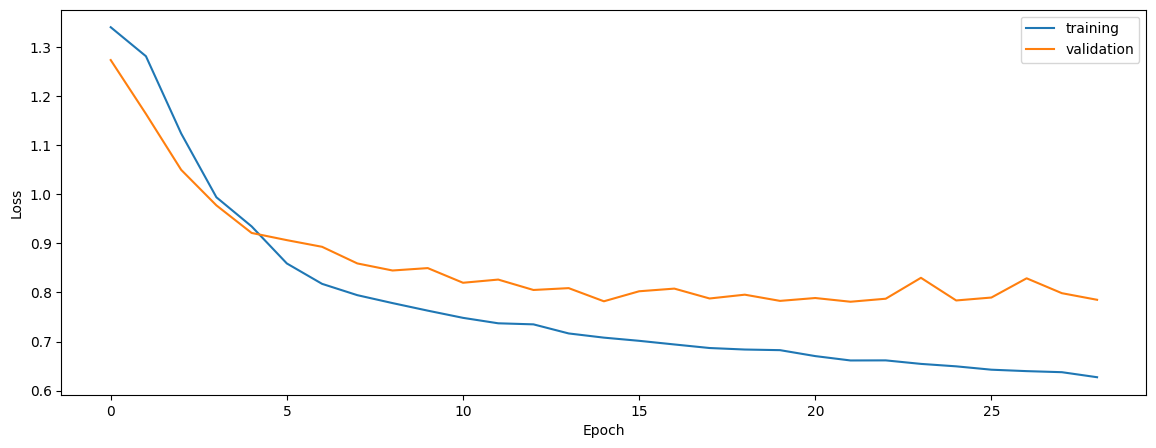

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.737757765326097
0.7014755847029077
0.7029568805112855


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.737757765326097
0.7014755847029077
0.7029568805112855


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.7336351628863567
0.7052403520649966
0.7048813701936384


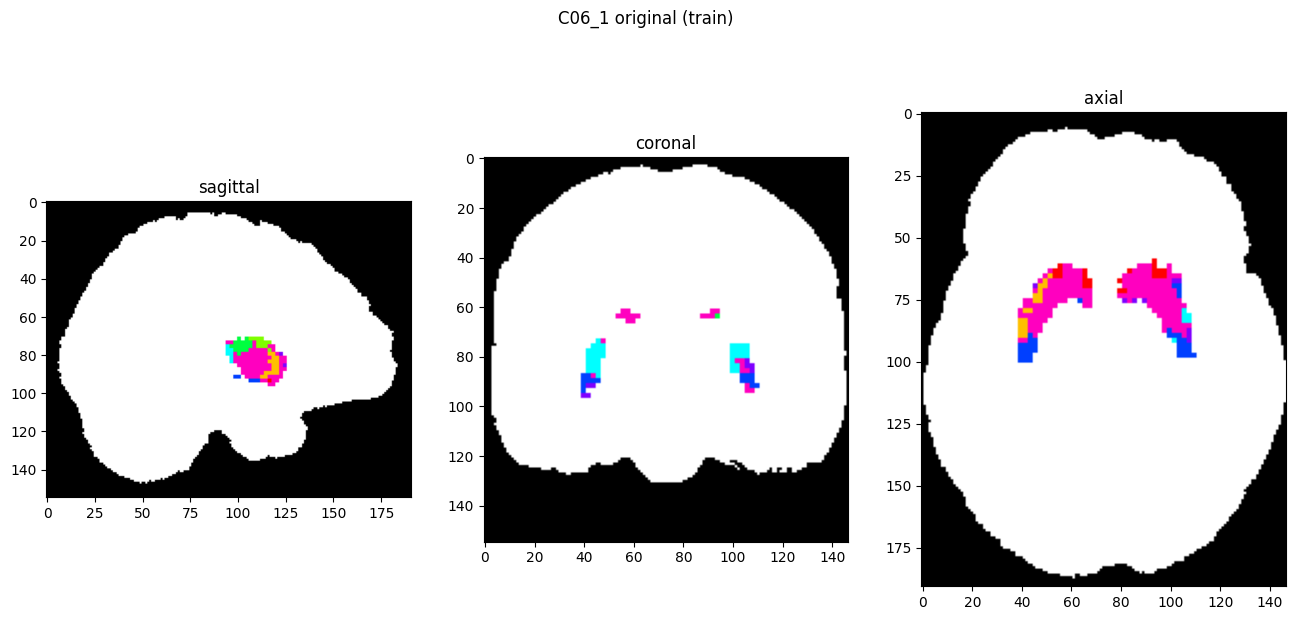

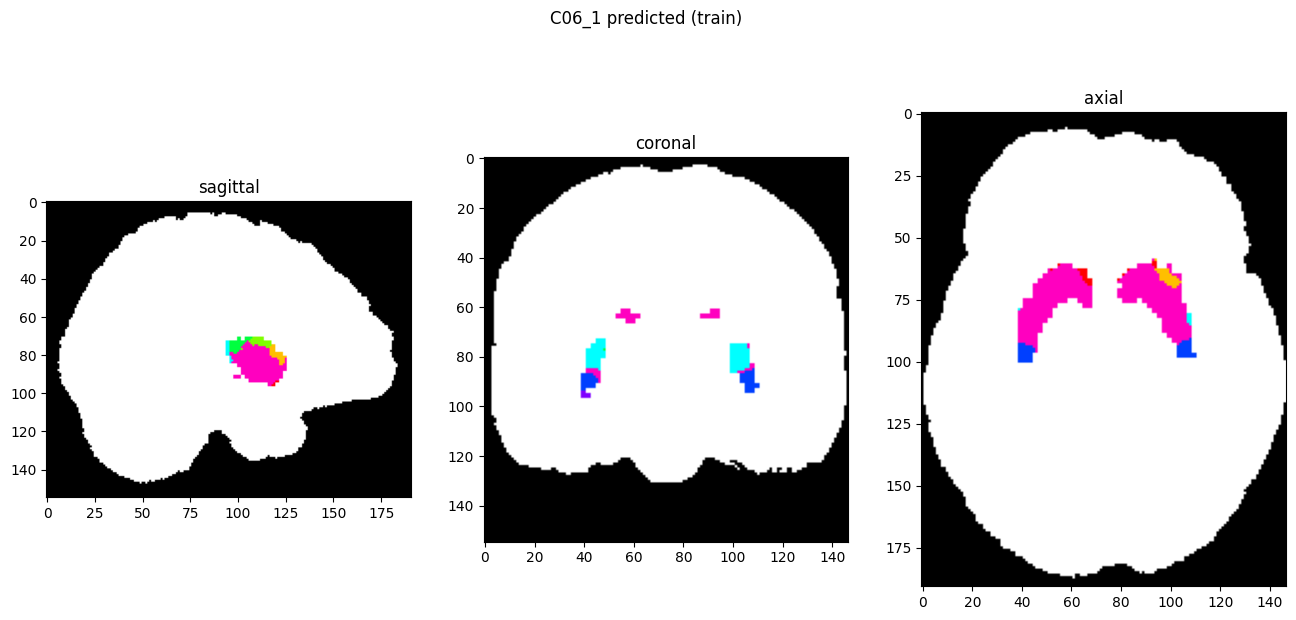

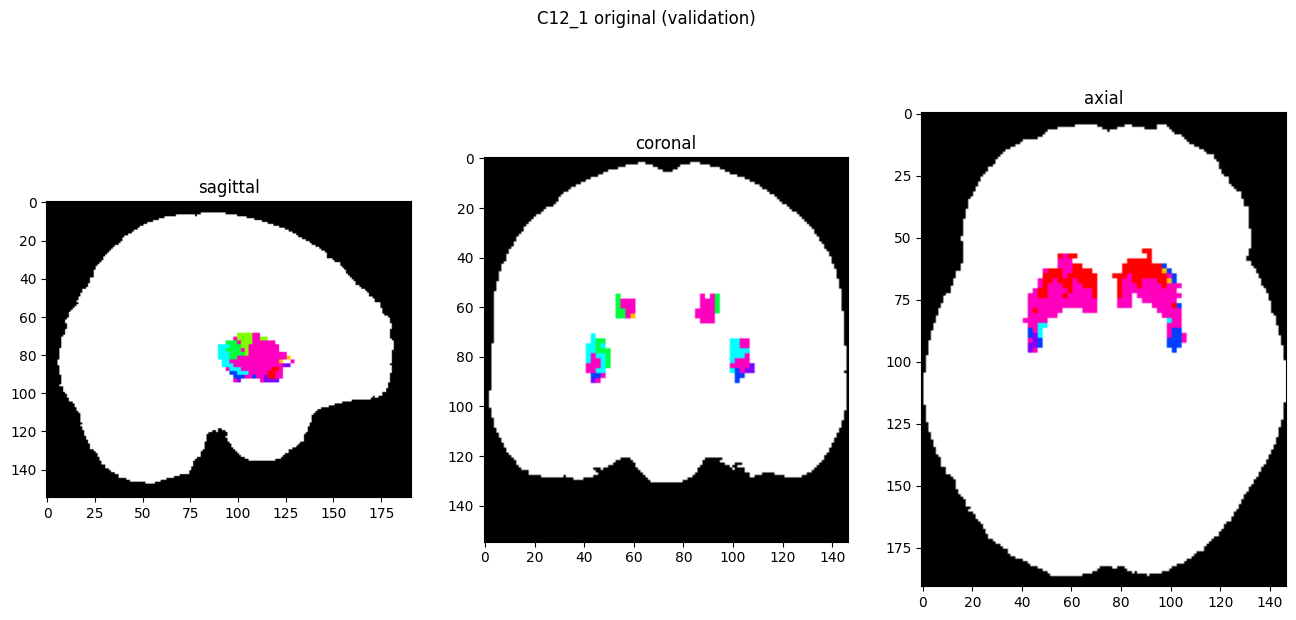

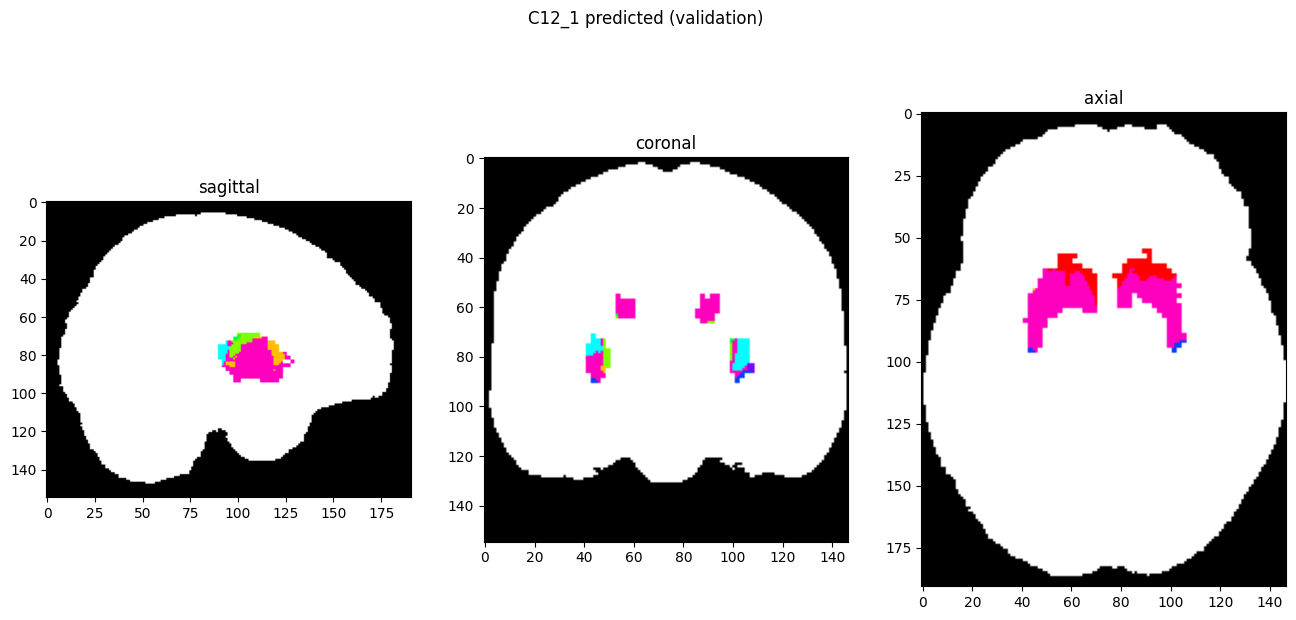

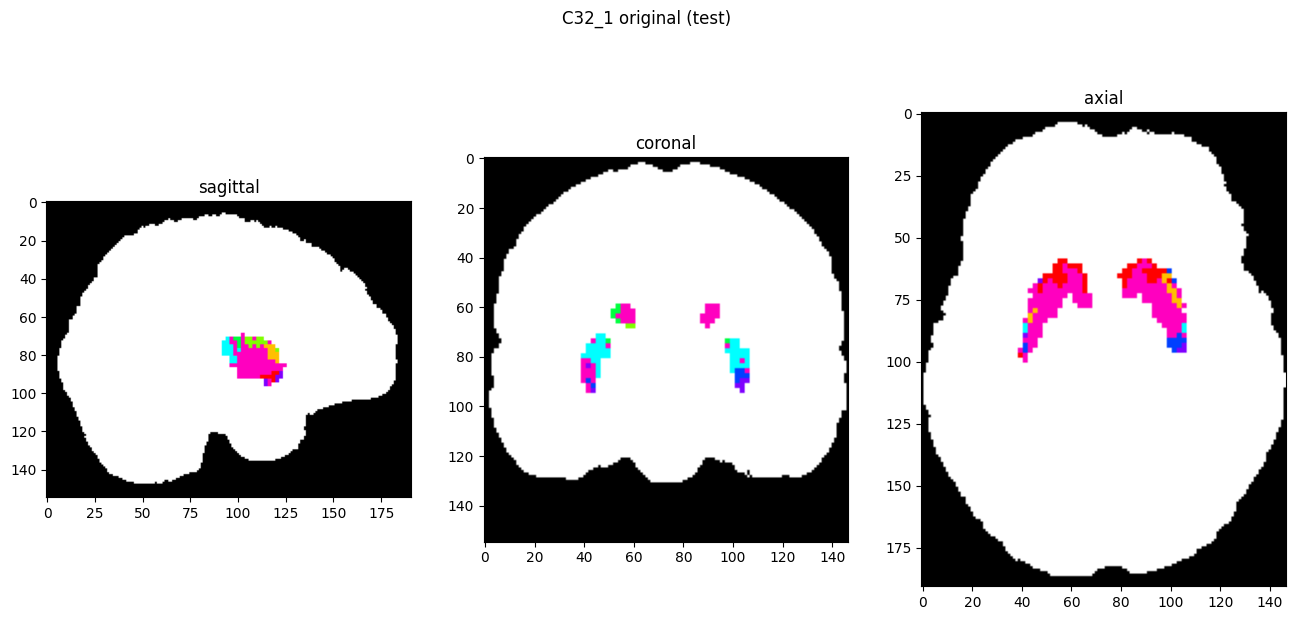

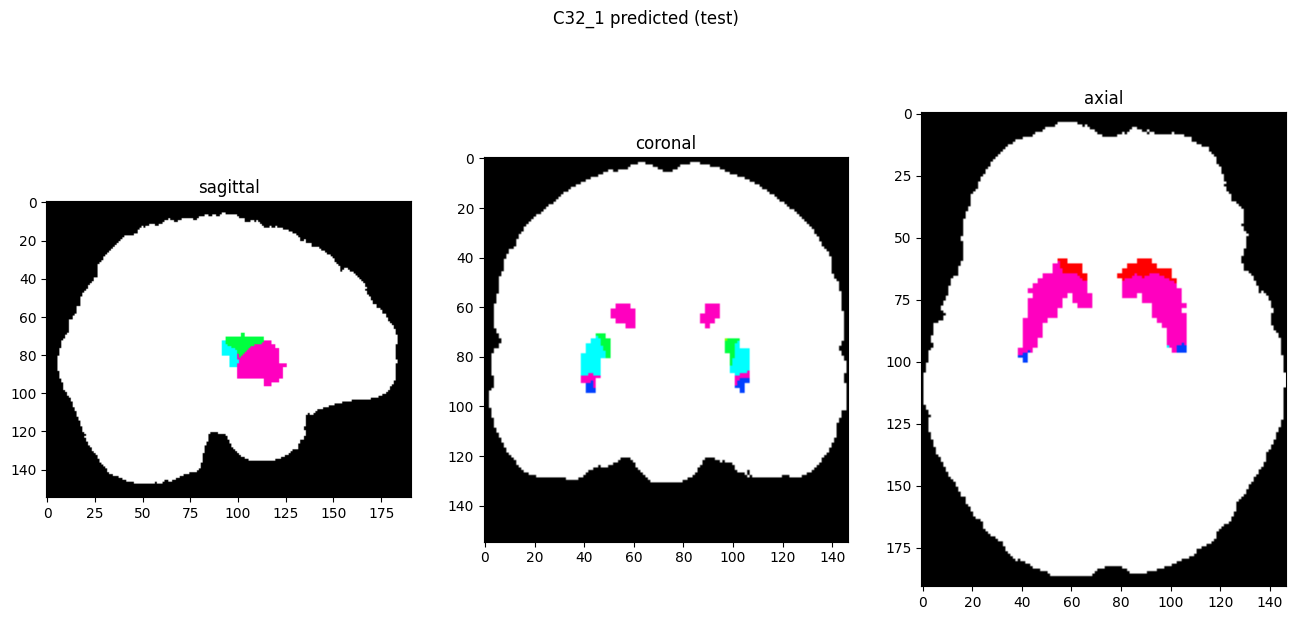

In [10]:
showResults(model, gen, threshold=0)